# Data analysis with SciAnalysis

last updated: 2023 May

In this notebook, we can load the raw tiff, load or extract metedata, analysis the data, save the analysis results and metadata in .H5.

--------------------------------------

*exp.dict*: The experiment dictionary. 'Experiment' is a series of measurements, e.g. in-situ thermal annealing measurements of a sample.

*exp.dict.keys()*: ['analysis', 'corr', 'corrdata', 'data', 'detector', 'exp_protocol', 'expinfo', 'expname', 'folder', 'mdata_list', 'metadata']

--------------------------------------

# &#9635; SciAnalysis for Experiment

At home insitute, download SciAnalysis at: https://github.com/CFN-softbio/SciAnalysis



In [2]:
#%matplotlib nbagg
# Imports
########################################
import sys, os, time, glob, imageio, datetime, pprint, math
import sqlite3
import pandas as pd
from silx.io.dictdump import dicttoh5, h5todict

SciAnalysis_PATH='/nsls2/data/cms/legacy/xf11bm/software/SciAnalysis/' ### Specify this
SciAnalysis_PATH in sys.path or sys.path.append(SciAnalysis_PATH)

from SciAnalysis import tools
from SciAnalysis.XSAnalysis.Data import *
from SciAnalysis.XSAnalysis import Protocols
from SciAnalysis.ExpAnalysis import Experiment
from SciAnalysis.ExpAnalysis import Tools

now = datetime.datetime.now()
dt_string = now.strftime("%Y/%m/%d %H:%M:%S")
print("{}\n".format(dt_string))

%pwd

2023/07/12 12:34:00



'/nsls2/data/cms/legacy/xf11bm/data/2023_2/GDoerk3'

&#9733; __NOTE__

For routine analysis, go to __Section 0__ for calibration and then jump to (__Section 7__ for stitching if needed) __Section 6__ for batch processing 

For real-time analysis of series data, go through other sections.

## 0. Calibration

#### __Direct beam__

['/nsls2/data/cms/legacy/xf11bm/data/2023_2/GDoerk3/saxs/raw/AgBH_cali_2m_13.5kev_directbeam_x0.000_th0.000_1.00s_1135305_saxs.tiff']
Size = (1679, 1475)
Beam center = [757, 1078]
Beam center = [758, 1078]


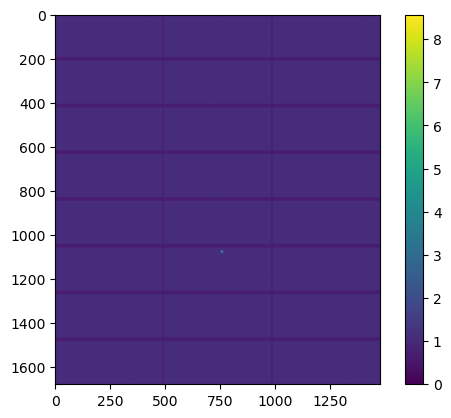

In [3]:
EXPR_DIR = '/nsls2/data/cms/legacy/xf11bm/data/2023_2/GDoerk3/saxs/'
pattern = '*directbeam*'
infiles = glob.glob(os.path.join(EXPR_DIR+'raw/', pattern+'.tiff'))

#infiles = sorted(infiles, key=lambda x: x.split('_saxs')[0].split('_')[-1]) 
print(infiles)

if len(infiles)>0:
    data = Data2DScattering()
    data.load(infiles[-1])
    #data.blur(sigma=1)
    img = data.data
    print('Size = {}'.format(img.shape))

    ## Plot
    %matplotlib inline
    plt.figure(1); plt.imshow(np.log(img+3)); plt.colorbar()
    beam_center = [np.argmax(np.max(img,0)), np.argmax(np.max(img,1))]
    print('Beam center = {}'.format(beam_center))

    img[beam_center[1], beam_center[0]] = 0
    beam_center = [np.argmax(np.max(img,0)), np.argmax(np.max(img,1))]
    print('Beam center = {}'.format(beam_center))
else:
    print('No matching files found')

#### __&#9733; Calibration AgBH__

Energy, beam center, SD distance

1. Specify wavelength 
2. Tweak beam center and SD distance to get the best match for the calibrant

/nsls2/data/cms/legacy/xf11bm/data/2023_2/GDoerk3/waxs/raw/
Loading 2 files
Loaded 4 files.
(defFiles time = 0.0s)
/nsls2/data/cms/legacy/xf11bm/data/2023_2/GDoerk3//waxs/analysis/calibration_check/

Calibration qlist = [0.1076 0.2152 0.3228 0.4304 0.538  0.6456 0.7532 0.8608 0.9684 1.076
 1.1836 1.2912 1.3988 1.5064 1.614  1.7216 1.8292 1.9368 2.0444 2.152 ]

fit_param = [height, width, prominence]
10 peaks found: [0.2131 0.3222 0.4312 0.5356 0.6446 1.371  2.0203 2.3336 2.8512 3.3098] for fit_prom 0.22521
fit_param = [height, width, prominence]
9 peaks found: [0.3262 0.4347 0.5429 0.6508 0.7583 1.3754 1.6329 1.8226 2.0214] for fit_prom 0.17914


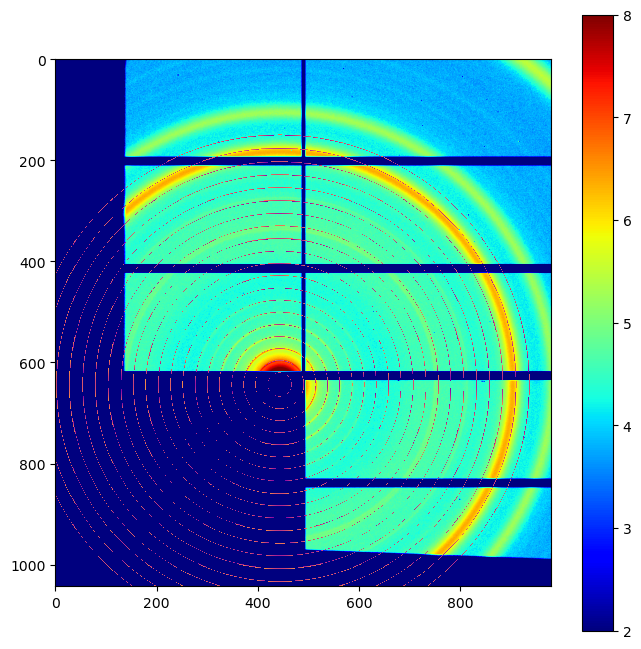

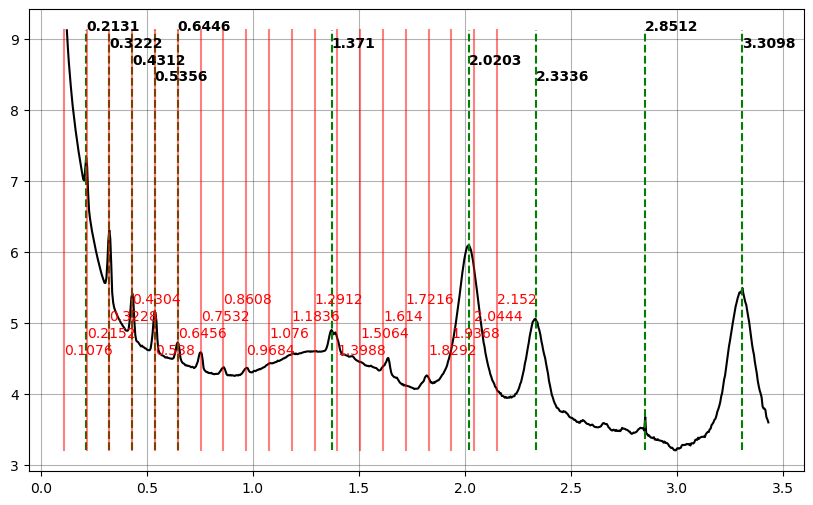

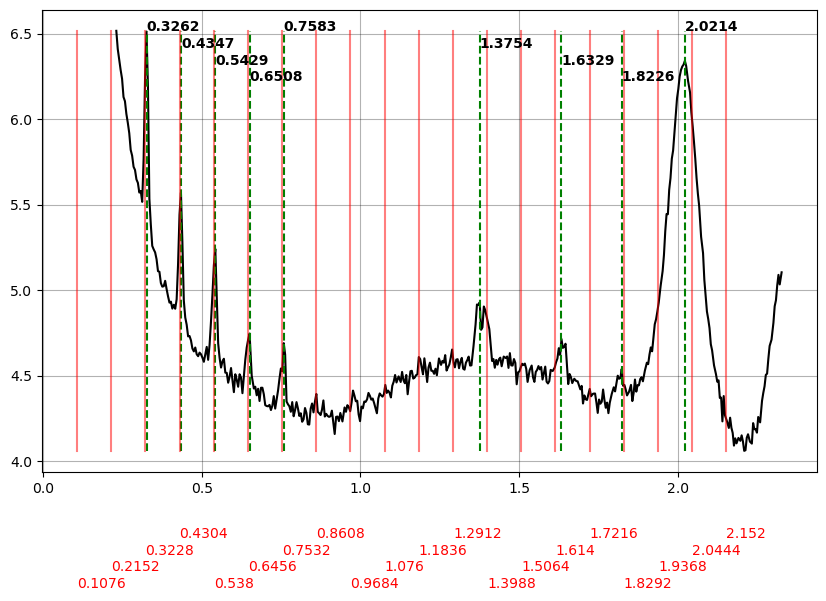

In [19]:
EXPR_DIR = '/nsls2/data/cms/legacy/xf11bm/data/2023_2/GDoerk3/' 
exp = Experiment.experiment('Ag', folder=EXPR_DIR, det='waxs', series_measure=False, beamline='None') ##Experiment name: rbitrary or related to the sample name
pattern = '*Ag*'
       
exp.defFiles(fn=pattern, verbose=0)     
infiles = exp.dict['rawinfo']['filename']
Nfiles = len(infiles)
    
#calibration = Calibration(wavelength_A=0.7293) # 17 keV
calibration = Calibration(wavelength_A=0.9184) #13.5 keV
calibration.set_image_size(981, height=1043) # Pilatus1M
calibration.set_pixel_size(pixel_size_um=172.0)
calibration.set_beam_position(443, 644.5) 

calibration.set_distance(0.2595)
#calibration.set_distance(0.2815)
mask_dir = SciAnalysis_PATH + '/SciAnalysis/XSAnalysis/masks/'
mask = Mask(mask_dir+'Dectris/Pilatus800k_gaps-mask.png')
   
    
load_args = { 'calibration' : calibration, 
             'mask' : mask,
             }
run_args = { 'verbosity' : 3,
             'AgBH': True, 
             'CeO2': False
           }
process = Protocols.ProcessorXS(load_args=load_args, run_args=run_args)

### Load & analyze the One file
exp.defFiles(fn=pattern, verbose=1)     
det = exp.dict['expinfo']['det']
folder = exp.dict['expinfo']['folder']
infile_fullpath = folder+'/'+det+'/raw/'+exp.dict['rawinfo']['filename'][-1]+'_'+det+'.tiff'

data = process.load(infile_fullpath, calibration=calibration, mask=mask, run_args=run_args)
circular_average_0 = data.circular_average_q_bin(error=False)
linecut_qr_0 = data.linecut_qr(qz=0, dq=0.02) 

### Save to PNG for defining mask in GIMP
output_dir = folder+'/'+det+'/analysis/calibration_check/'
print(output_dir)
tools.make_dir(output_dir)
outfile = output_dir + data.name + '.png'
data.plot_image(outfile, **run_args)


## Plot 2D 
%matplotlib inline
#%matplotlib ipympl

if 1:
    plt.figure(1, figsize=(8,8)); plt.clf()
    plt.imshow(np.log(data.data+3), vmin=2, vmax=8, cmap='jet'); plt.colorbar() 

    dq = 0.01
    qlist = []
    if 'AgBH' in run_args and run_args['AgBH']:
        q0 = 0.1076
        num_rings = 20
        qlist.extend(q0*np.arange(1,num_rings+1))       
        
    if 'CeO2' in run_args and run_args['CeO2']:
        q0 = (2*np.pi/5.411)*np.sqrt(3)          # A^-1, (111)
        qlist.extend( ( q0/np.sqrt(3) )*np.array((np.sqrt(3), 2, np.sqrt(8),np.sqrt(11),np.sqrt(12),np.sqrt(16),np.sqrt(19),  np.sqrt(20)))  )
    
    qlist.sort();     qlist = np.asarray(qlist)
    print('\nCalibration qlist = {}\n'.format(qlist))    
    
    for q in qlist:
        region = data.calibration.q_map()
        region = np.ma.masked_where(abs(region-q)>dq, region)
        plt.imshow(region, cmap='plasma')

## Plot 1D 
if 1:
    flag_log = 1
    for ii, line in enumerate([circular_average_0, linecut_qr_0]):
        plt.figure(ii+2, figsize=(10,6)); plt.clf()
        q_peaks = Tools.plot_peaks(line, N_peaks_find = 10, fit_param=[0, 1, 0.01], flag_log=flag_log, line_color='k', label_color='g', roundup=4, verbose=1)  #Tools.rand_color(0.5, 0.8)

        y_range = [np.min(line.y), np.max(line.y)]
        qlist[qlist > np.max(line.x)] = None
        Tools.label_peaks(qlist, flag_log=flag_log, y_range = y_range, color='r', roundup=4, verbose=1) 
   

#### __Convert q <--> angle__

In [13]:
print('At {} keV'.format(calibration.get_energy()))
print(data.calibration.q_to_angle(1))
print(data.calibration.angle_to_q(20))

At 13.500018665493208 keV
8.38227707099533
2.376009752908029


## 1. Raw data

In [55]:
### Specify directory, detector, and files of interest
if 0: #SAXS
    EXPR_DIR = '/nsls2/data/cms/legacy/xf11bm/data/2023_2/beamline/CKe/'
    exp = Experiment.experiment('Ag', folder=EXPR_DIR, det='saxs', beamline='cms') ##Experiment name: rbitrary or related to the sample name
    exp.dict['expinfo']['fn_patterns'] = ['*Ag*1016533*']  

if 1: #WAXS, temperature
    EXPR_DIR = '/nsls2/data/cms/legacy/xf11bm/data/2023_1/beamline/ETsai2/'  ##SA
    exp = Experiment.experiment('PBG_run1', folder=EXPR_DIR, det='waxs', beamline='cms') 
    exp.dict['expinfo']['fn_patterns'] = ['*_PBG*run1*x0.0*y0.0*10133*']  #*10133

if 0: #WAXS mapping
    EXPR_DIR = '/nsls2/data/cms/legacy/xf11bm/data/2022_3/RHeadrick3/' 
    exp = Experiment.experiment('B6_N3', folder=EXPR_DIR, det='waxs', beamline='cms')
    exp.dict['expinfo']['fn_patterns'] = ['*B6_N3_Trans3_map_vac_x*']  

if 0: #MAXS burstmode (series)
    EXPR_DIR = '/nsls2/data/cms/legacy/xf11bm/data/2023_1/LRichter2/MM389_KCl/' 
    exp = Experiment.experiment('MM389_KCl', folder=EXPR_DIR, det='maxs', series_measure=True, beamline='cms') ##Experiment name: rbitrary or related to the sample name
    exp.dict['expinfo']['fn_patterns'] = ['*MM389*run4*']  
      
if 1: 
    EXPR_DIR = '/nsls2/data/cms/legacy/xf11bm/data/2023_2/CKe/' 
    exp = Experiment.experiment('CK', folder=EXPR_DIR, det='saxs', series_measure=False, beamline='None') ##Experiment name: rbitrary or related to the sample name
    exp.dict['expinfo']['fn_patterns'] = ['CK*']  
      
    
    
    
    
### Load files
try:
    for pattern in exp.dict['expinfo']['fn_patterns']:
        #exp.defFiles_query(fn='PBG', folder=EXPR_DIR, scanid = [900000, 1200000], verbose=1) 
        exp.defFiles(fn=pattern, verbose=1) 
        #exp.defFiles(fn=pattern, scanid = [750000, 900000], verbose=1)  
    
    infiles = exp.dict['rawinfo']['filename']
    Nfiles = len(infiles)
    
except:
    print('\n!!! Databroker not working, loading files directly.')
    #exp.dict['expinfo']['beamline'] = None
    for pattern in exp.dict['expinfo']['fn_patterns']:
        exp.defFiles(fn=pattern, verbose=1)      
    

### Show some info   
exp.show()
exp.showFileInfo(idx=0)


/nsls2/data/cms/legacy/xf11bm/data/2023_2/CKe/saxs/raw/
Loading 68 files
Loaded 68 files.
(defFiles time = 0.0s)

=== Overview of experiment dictionary ===
exp.dict['expinfo']
  -  keys = ['expname', 'det', 'beamline', 'folder', 'ext', 'fn_patterns']
  -  key = expname, <class 'str'>, val = CK
  -  key = det, <class 'str'>, val = saxs
  -  key = beamline, <class 'str'>, val = None
  -  key = folder, <class 'str'>, val = /nsls2/data/cms/legacy/xf11bm/data/2023_2/CKe/
  -  key = ext, <class 'str'>, val = tiff
  -  key = fn_patterns, <class 'list'>, val = ['CK*']
exp.dict['rawinfo']
  -  keys = ['filename', 'time', 'clock', 'scan_id', 'uid', 'filenumber', 'series_measure', 'num_frames']
  -  key = filename, <class 'list'>, len(shape) = 68
  -  key = time, <class 'list'>, val = []
  -  key = clock, <class 'list'>, val = []
  -  key = scan_id, <class 'list'>, len(shape) = 68
  -  key = uid, <class 'list'>, val = []
  -  key = filenumber, <class 'int'>, val = 68
  -  key = series_measure, <c

## 2. (Optional) Metadata

#### __Databroker__

In [ ]:
## Check databroker or load some scan info

import databroker, datetime
cat = databroker.catalog['cms']
#scan_id = exp.dict['rawinfo']['scan_id'][0]  #959455
scan_id =  1135011 #1135011 #1134889 #1134846 #1135309
h = cat[scan_id]

print(h.metadata['start']['experiment_alias_directory'])
print('empty scan: ', scan_id)
for scan_id in range(scan_id-5, scan_id+6):
    h = cat[scan_id]

    dt = datetime.datetime.fromtimestamp(h.metadata['start']['time'])
    det = h.metadata['start']['detectors']
    ct = h.metadata['start']['sample_exposure_time']

    #h.metadata['start']

    print('scanid {}, time {}, det {}, exposure {}s'.format(scan_id, dt, det, ct))
    #print('scanid ', scan_id, dt, det)


__Browse metadata__

In [191]:
## See metadata for one file
import databroker
cat = databroker.catalog['cms']
scan_id = exp.dict['rawinfo']['scan_id'][0]  #959455
h = cat[scan_id]
h.metadata['start']


Start({'beam_int_bim3': 0.0,
 'beam_int_bim4': 0.0,
 'beam_int_bim5': 0.0,
 'beam_intensity_expected': 20000,
 'beam_size_x_mm': 0.1999979999999999,
 'beam_size_y_mm': 0.049985999999999864,
 'beamline_mode': 'measurement',
 'calibration_energy_keV': 13.5,
 'calibration_wavelength_A': 0.9184,
 'detector_sequence_ID': 0,
 'detectors': ['pilatus2M', 'pilatus800'],
 'experiment_SAF_number': '310000',
 'experiment_alias_directory': '/nsls2/data/cms/legacy/xf11bm/data/2023_2/beamline/RLi2/',
 'experiment_cycle': '2023_2',
 'experiment_group': 'beamline',
 'experiment_project': 'beamline',
 'experiment_proposal_number': '\r',
 'experiment_type': 'GISAXS,GIWAXS',
 'experiment_user': 'beamline',
 'filename': 'B5-80-1_1098.4s_x0.000_th0.120_10.00s_1025967',
 'hints': {'dimensions': [[['time'], 'primary']]},
 'measure_type': 'measure',
 'motor_SAXSx': -65.0,
 'motor_SAXSy': -73.00000558,
 'motor_WAXSx': -260.0,
 'motor_WAXSy': 39.999984375000004,
 'motor_WAXSz': -142.0,
 'motor_smx': -17.2,
 'mot

In [192]:
### Check metadata at the beamline, identify md of interest, e.g. sample_temperature_D, sample_x
file_idx = 0
scan_id = exp.dict['rawinfo']['scan_id'][file_idx]
#exp.showMetadata(scanid=scan_id, md_interest=None)
exp.showMetadata(scanid=scan_id, md_interest = ['sample_clock', 'sample_x'])
#exp.showMetadata(scanid=scan_id, md_interest = ['sample_clock', 'sample_x', 'sample_y'])

### Scan 1025967:
sample_clock: 1098.3881704807281

sample_x: 0.0



#### __Load metadata__

In [207]:
## Options: 
## (1) load metadata from databroker at beamline. 
## (2) load md from h5. 
## (3) Extract info from filename
md_load_option = 1

## Clear all metadata
exp.dict['metadata'] = {}


## Load metadata
if md_load_option==1: # Load md from databroker, this only works at beamline
    exp.dict['mdata_list'] = ['sample_clock'] # Specify metedata to load
    exp.loadMetadata()
    print(exp.dict['metadata'].keys())
    
elif md_load_option==2: # Load md from h5 (previously saved from databroker)
    h5_path = EXPR_DIR+"/data/"
    h5_file = 'B6_N3_metadata.h5'
    exp.dict['metadata'] = h5todict(h5_path+h5_file)


elif md_load_option==3: ## If databroker md is not available nor saved
    infiles = exp.dict['rawinfo']['filename']
    print('Number of files: {}'.format(len(infiles)))

    Ts = []
    sample_x = []
    sample_y = []
    scan_id = []
    frames = []
    for ii, infile in enumerate(infiles):
        temp = infile.split('_')
        if ii==0: print(temp)
        
        Ts.append(float(infile.split('Linkam')[1].split('C')[0]))
        #sample_x.append(float(temp[-4][1:]))
        #sample_y.append(float(temp[-3][1:]))
        
        #Ts.append(float(infile.split('RH')[1].split('_x')[0]))
        #scan_id.append(int(temp[-1]))
        #frames.append(int(temp[-1]))

    exp.dict['metadata']['sample_temperature_D'] = Ts
    #exp.dict['metadata']['sample_x'] = np.array(sample_x)
    #exp.dict['metadata']['sample_y'] = np.array(sample_y)
    #exp.dict['metadata']['frames'] = frames
    
    print(exp.dict['metadata'].keys())

else:
    print('No metadata loaded to the exp. dictionary!')

[0%] 
[90%] 
(loadMetadata time = 2.8s)
dict_keys(['sample_clock'])


In [208]:
exp.show()


=== Overview of experiment dictionary ===
exp.dict['expinfo']
  -  keys = ['expname', 'det', 'beamline', 'folder', 'fn_patterns']
  -  key = expname, <class 'str'>, val = B5
  -  key = det, <class 'str'>, val = saxs
  -  key = beamline, <class 'str'>, val = cms
  -  key = folder, <class 'str'>, val = /nsls2/data/cms/legacy/xf11bm/data/2023_2/beamline/RLi2/
  -  key = fn_patterns, <class 'list'>
exp.dict['rawinfo']
  -  keys = ['filename', 'time', 'clock', 'scan_id', 'uid', 'filenumber', 'series_measure', 'num_frames']
  -  key = filename, <class 'list'>, len(shape) = 223
  -  key = time, <class 'list'>, len(shape) = 223
  -  key = clock, <class 'list'>, len(shape) = 223
  -  key = scan_id, <class 'list'>, len(shape) = 223
  -  key = uid, <class 'list'>, len(shape) = 223
  -  key = filenumber, <class 'int'>, val = 223
  -  key = series_measure, <class 'bool'>, val = False
  -  key = num_frames, <class 'list'>, val = []
exp.dict['analysis']
exp.dict['metadata']
  -  keys = ['sample_cloc

In [ ]:
### Save metadata (for offline analysis later on)
if 0:
    h5_path = EXPR_DIR+"/data/"
    h5_file = exp.name+'_metadata.h5'
    dicttoh5(exp.dict['metadata'], h5_path+h5_file)
    print(h5_path+h5_file)


## 3. Analysis

We suspect that loading analysis results is slow, faster if processing raw data. However, going through the protocals is also slow; storing it to the exp.dict also takes a bit time.

E.g. 3600 files, 1 protocol, saving to exp.dict: 5min

In [240]:
### Specify beamline config (e.g. beam energy, center, det-sample distance)

if 0: #WAXS, MAXS
    #calibration = Calibration(wavelength_A=0.7293) # 17 keV
    calibration = Calibration(wavelength_A=0.9184) #13.5 keV
    calibration.set_image_size(981, height=1043) # Pilatus1M
    calibration.set_pixel_size(pixel_size_um=172.0)
    calibration.set_beam_position(313.5, 1043-314) #SA, 2023 Apr
    calibration.set_distance(0.259)

    ## LRichter
    if 0:
        calibration.set_beam_position(543, 606) #LRichter
        calibration.set_distance(0.2815)
    
    mask_dir = SciAnalysis_PATH + '/SciAnalysis/XSAnalysis/masks/'
    mask = Mask(mask_dir+'Dectris/Pilatus800k_gaps-mask.png')
    #mask.load(mask_dir+'NSLSII_11BM_CMS/Pilatus800k_CMS_badpixels-mask.png ')

if 0: #SAXS   
    calibration = Calibration(wavelength_A=0.9184) # 13.5 keV
    calibration.set_image_size(1475, height=1679) # Pilatus2M
    calibration.set_pixel_size(pixel_size_um=172.0)

    calibration.set_beam_position(757, 1679-600) # SAXSx -65, SAXSy -73    
    calibration.set_distance(5.02)    

    mask_dir = SciAnalysis_PATH + '/SciAnalysis/XSAnalysis/masks/'
    if 1: #flag_stitch
        mask = Mask(mask_dir+'Dectris/Pilatus2M_vertical_gaps-mask.png')
    else:
        mask = Mask(mask_dir+'Dectris/Pilatus2M_gaps-mask.png')
    mask.load(EXPR_DIR+'saxs/analysis/mask_saxs.png')    
    
    
load_args = { 'calibration' : calibration, 
             'mask' : mask,
             #'rot180' : False,
             #'flip' : True, # PSCCD
             }
run_args = { 'verbosity' : 3,
            #'save_results' : ['xml', 'plots', 'txt', 'hdf5'],
            }
process = Protocols.ProcessorXS(load_args=load_args, run_args=run_args)
#infiles = exp.dict['expinfo']['filename']


### Run analysis 
protocols = ['linecut_qr'] #['linecut_angle'] #['circular_average'] #, 'sector_average', 'linecut_qz']

exp.dict['analysis']['cali'] = [calibration.wavelength_A, calibration.x0, calibration.y0, calibration.distance_m]
#exp.dict['analysis'] = {} 
#for protocol in protocols:
#    exp.dict['analysis'][protocol] = {}

t0 = time.time()  
    
line_y_stack = []
for protocol in protocols:
    if 'circular_average' in protocol:
        for ii, infile in enumerate(infiles):
            if np.mod(ii+1, 50)==0: print('[{:.0f}%]'.format(ii/Nfiles*100))

            det = exp.dict['expinfo']['det']
            folder = exp.dict['expinfo']['folder']

            infile_fullpath = folder+'/'+det+'/raw/'+exp.dict['rawinfo']['filename'][ii]+'_'+det+'.tiff'
            data = process.load(infile_fullpath, calibration=calibration, mask=mask, run_args=run_args)

            ### Run the protocol
            line_output = data.circular_average_q_bin(error=False)
            line_y_stack.append(line_output.y)

            if 0:
                exp.dict['analysis'][protocol][str(ii)] = {}
                exp.dict['analysis'][protocol][str(ii)]['q'] = line_output.x
                exp.dict['analysis'][protocol][str(ii)]['I(q)'] = line_output.y
        
        ### Save analysis to exp.dict
        if 1:
            exp.dict['analysis'][protocol] = {}
            exp.dict['analysis'][protocol]['q'] = line_output.x
            exp.dict['analysis'][protocol]['I_stack'] = line_y_stack   
            #x = Protocols.thumbnails(name=None) 
            #x.run(data, output_dir)
            
    if 'linecut_qr' in protocol:
        for ii, infile in enumerate(infiles):
            if np.mod(ii+1, 50)==0: print('[{:.0f}%]'.format(ii/Nfiles*100))

            det = exp.dict['expinfo']['det']
            folder = exp.dict['expinfo']['folder']

            infile_fullpath = folder+'/'+det+'/raw/'+exp.dict['rawinfo']['filename'][ii]+'_'+det+'.tiff'
            data = process.load(infile_fullpath, calibration=calibration, mask=mask, run_args=run_args)

            ### Run the protocol
            line_output = data.linecut_qr(qz=0.03, dq=0.003)
            line_y_stack.append(line_output.y)

        ### Save analysis to exp.dict
        if 1:
            exp.dict['analysis'][protocol] = {}
            exp.dict['analysis'][protocol]['q'] = line_output.x
            exp.dict['analysis'][protocol]['I_stack'] = line_y_stack           
        
    #elif 'sector_average' in protocol: 
    #    line_output = data.sector_average_q_bin(angle=60, dangle=5)

    #elif 'linecut_qz' in protocol:
    #    line_output = data.linecut_qz(qr=0, dq=0.05)

    #elif 'linecut_angle' in protocol:
    #line_output = data.linecut_angle(q0=2.24, dq=0.01)
            
        
print('Done! (Analysis took {:.0f}s)\n'.format(time.time()-t0))

now = datetime.datetime.now()
dt_string = now.strftime("%Y/%m/%d %H:%M:%S")
print("{}\n".format(dt_string))

print(exp.dict['analysis'].keys())

[19%]
[39%]
[58%]
[78%]
[97%]
Done! (Analysis took 11s)

2023/05/11 17:23:04

dict_keys(['cali', 'linecut_qr'])


#### __Show Region__

In [ ]:
infile = infiles[0]
print(infile)

#infile_fullpath = folder+'/'+det+'/raw/'+exp.dict['rawinfo']['filename'][ii]+'_'+det+'.tiff'
infile_fullpath = folder + '/' + exp.dict['rawinfo']['filename'][ii]+ '_' + det + '.tif'
data = process.load(infile_fullpath, calibration=calibration, mask=mask, run_args=run_args)

## Plot scattering data
q_data = data.remesh_qr_bin(**run_args)
x_axis, y_axis = q_data.xy_axes()
extent = [x_axis[0], x_axis[-1], y_axis[0], y_axis[-1]]

plt.figure(100, figsize=(8,8)); plt.clf()
#plt.imshow(np.log(data.data+3), vmin=2, vmax=7); plt.colorbar() 
plt.imshow(np.log(q_data.data+3), vmin=2, vmax=7, cmap='jet', interpolation='nearest', extent=extent, origin='lower'); plt.colorbar()


### Linecut
qz = 0.05; dq = 0.002
region = data.calibration.q_map()
region = np.ma.masked_where(abs(data.calibration.qz_map()-qz)>dq, data.calibration.qr_map())

qr = 0.05
region = np.ma.masked_where(abs(data.calibration.qr_map()-qr)>dq, data.calibration.qz_map())
plt.imshow(region, cmap='plasma', extent=extent)
   
### Angle
q0 = 0.05;
dq = 0.001;
region = np.ma.masked_where(abs(data.calibration.q_map()-q0)>dq, data.calibration.angle_map())
plt.imshow(region, cmap='plasma', extent=extent)
   
### Sector
angle = 0
dangle = 5
region =  np.ma.masked_where(abs(data.calibration.angle_map()-angle)>dangle/2, data.calibration.q_map())
plt.imshow(region, cmap='plasma', extent=extent)
    

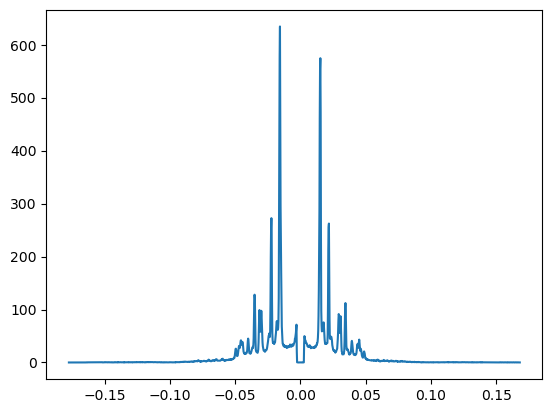

In [236]:
plt.plot(line_output.x, line_output.y)

In [210]:
exp.show()


=== Overview of experiment dictionary ===
exp.dict['expinfo']
  -  keys = ['expname', 'det', 'beamline', 'folder', 'fn_patterns']
  -  key = expname, <class 'str'>, val = B5
  -  key = det, <class 'str'>, val = saxs
  -  key = beamline, <class 'str'>, val = cms
  -  key = folder, <class 'str'>, val = /nsls2/data/cms/legacy/xf11bm/data/2023_2/beamline/RLi2/
  -  key = fn_patterns, <class 'list'>
exp.dict['rawinfo']
  -  keys = ['filename', 'time', 'clock', 'scan_id', 'uid', 'filenumber', 'series_measure', 'num_frames']
  -  key = filename, <class 'list'>, len(shape) = 223
  -  key = time, <class 'list'>, len(shape) = 223
  -  key = clock, <class 'list'>, len(shape) = 223
  -  key = scan_id, <class 'list'>, len(shape) = 223
  -  key = uid, <class 'list'>, len(shape) = 223
  -  key = filenumber, <class 'int'>, val = 223
  -  key = series_measure, <class 'bool'>, val = False
  -  key = num_frames, <class 'list'>, val = []
exp.dict['analysis']
  -  keys = ['cali', 'circular_average']
  -  

__Instead of doing analysis, can load previously analyzed data__

In [468]:
if 0:
    exp.loadSciAnalysisData(keys=['circular_average'], analysis_folder=str(exp.dict['folder'])+'waxs/analysis/PBG_run1/', verbose=1)
    exp.dict['analysis'].keys()

analysis_folder = /nsls2/data/cms/legacy/xf11bm/data/2023_1/beamline/ETsai2/waxs/analysis/PBG_run1/
[0%] 
[43%] 
[85%] 
loadSciAnalysisData time = 16.5s


dict_keys(['circular_average'])

## 4. Save 

Save experiment dictionary (exp.dict) to h5.

In [21]:
h5_path = EXPR_DIR+"/data/"
h5_file = str(exp.dict['expinfo']['expname']) + '_cms_exp.h5'
output_file = h5_path+h5_file


## Check if file exist, will not overwrite
if False:
    file_exist = os.path.isfile(output_file)
    count = 1
    while file_exist:
        print('{} exists, using a new filename'.format(output_file))
        h5_file = str(exp.dict['expname']) + '_exp_' + str(count) + '.h5'
        output_file = h5_path+h5_file
        file_exist = os.path.isfile(output_file)
        count = count + 1

        
## Save
dicttoh5(exp.dict, output_file)
print('Experiment saved as {}'.format(output_file))



Experiment saved as /nsls2/data/cms/legacy/xf11bm/data/2023_1/LRichter2/MM389_KCl//data/MM389_KCl_cms_exp.h5


In [22]:
exp_dict_load['expinfo']

{'det': array('maxs', dtype='<U4'),
 'expname': array('MM389_KCl', dtype='<U9'),
 'fn_patterns': array(['*MM389*run4*'], dtype=object),
 'folder': array('/nsls2/data/cms/legacy/xf11bm/data/2023_1/LRichter2/MM389_KCl/',
       dtype='<U62'),
 'beamline': 'None'}

### __Load H5__

Load experiment dictionary and recover the object 'exp', allowing for subsequent data visualization/analysis.

In [2]:
#%matplotlib nbagg
# Imports
########################################
import sys, os, time, glob, imageio, datetime, pprint
import sqlite3
import pandas as pd
from silx.io.dictdump import dicttoh5, h5todict
SciAnalysis_PATH='/nsls2/data/cms/legacy/xf11bm/software/SciAnalysis/' ### Specify this
SciAnalysis_PATH in sys.path or sys.path.append(SciAnalysis_PATH)
from SciAnalysis import tools
from SciAnalysis.XSAnalysis.Data import *
from SciAnalysis.XSAnalysis import Protocols
from SciAnalysis.ExpAnalysis import Experiment
from SciAnalysis.ExpAnalysis import Tools


### Load experiment dict (previuosly analyzed data)
if True:
    
    #exp_dict_h5 = '/nsls2/data/cms/legacy/xf11bm/data/2022_3/RHeadrick3//data/B6_N3_cms_exp.h5'
    #exp_dict_h5 = '/nsls2/data/cms/legacy/xf11bm/data/2023_1/beamline/ETsai2//data/PBG_run1_cms_exp.h5'
    exp_dict_h5 = '/nsls2/data/cms/legacy/xf11bm/data/2023_1/LRichter2/MM389_KCl//data/MM389_KCl_cms_exp.h5'
    exp_dict_load = h5todict(exp_dict_h5)
    #print(exp_dict_load.keys())
    
    exp = Experiment.experiment(exp_dict_load['expinfo']['expname'], folder=exp_dict_load['expinfo']['folder'], det=exp_dict_load['expinfo']['det'], beamline=exp_dict_load['expinfo']['beamline']) 
    exp.dict = exp_dict_load
    
    print(exp.dict.keys())
    print('\nExperiment loaded!')

dict_keys(['advanced', 'analysis', 'expinfo', 'metadata', 'rawinfo'])

Experiment loaded!


### __Overview of exp__

In [4]:
exp.show(verbose=1)


=== Overview of experiment dictionary ===
exp.dict['advanced']
  -  keys = []
exp.dict['analysis']
  -  keys = ['cali', 'circular_average']
  -  key = cali, <class 'numpy.ndarray'>, val = [9.184e-01 5.430e+02 6.060e+02 2.815e-01]
  -  key = circular_average
  -  -  keys = ['I_stack', 'q']
  -  -  key = I_stack, <class 'numpy.ndarray'>, val.shape = (3600, 748)
  -  -  key = q, <class 'numpy.ndarray'>, val.shape = (748,)
exp.dict['expinfo']
  -  keys = ['beamline', 'det', 'expname', 'fn_patterns', 'folder']
  -  key = beamline, <class 'numpy.ndarray'>, val = None
  -  key = det, <class 'numpy.ndarray'>, val = maxs
  -  key = expname, <class 'numpy.ndarray'>, val = MM389_KCl
  -  key = fn_patterns, <class 'numpy.ndarray'>, val = ['*MM389*run4*']
  -  key = folder, <class 'numpy.ndarray'>, val = /nsls2/data/cms/legacy/xf11bm/data/2023_1/LRichter2/MM389_KCl/
exp.dict['metadata']
  -  keys = ['frames', 'sample_temperature_D']
  -  key = frames, <class 'numpy.ndarray'>, val.shape = (3600,)
 

## 5. Plot

### __(5.1) Data Trend__

#### &#9642; __Plot curves__

##### - __Load one curve & find peaks__

linecut_qr
B5-80-1_3522.2s_x-2.000_th0.120_1.00s_1026225
fit_param = [height, width, prominence]
5 peaks found: [-0.1312 -0.0509 -0.003   0.003   0.1338] for fit_prom 0.92143


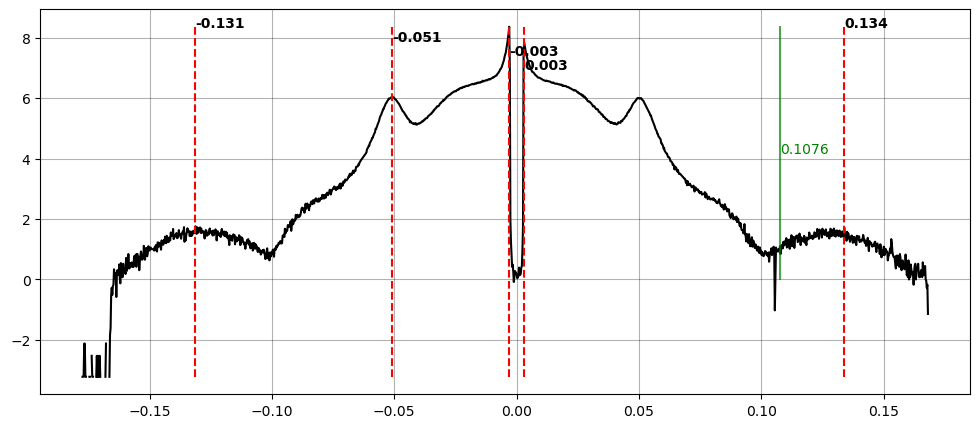

In [241]:
### Show one curve and find peaks

#protocol = 'circular_average'
protocol = list(exp.dict['analysis'].keys())[-1]
print(protocol)
print(exp.dict['rawinfo']['filename'][-1])

## Pick a curve
file_idx = 0
line_plot = DataLine(x = exp.dict['analysis'][protocol]['q'], y = exp.dict['analysis'][protocol]['I_stack'][file_idx])  
flag_log = 1

%matplotlib inline
#%matplotlib ipympl
plt.figure(1, figsize=(12,5)); plt.clf()
q_peaks = Tools.plot_peaks(line_plot, N_peaks_find = 5, fit_param=[0, 1, 0.001], flag_log=flag_log, line_color='k', label_color='r', verbose=1)  #Tools.rand_color(0.5, 0.8)

q_label = [0.1076]
for q in q_label:
    if flag_log:
        y_range = [0, max(np.log(line_plot.y))]
    else:
        y_range = [min(line_plot.y), max(np.log(line_plot.y))]
    plt.plot([q, q], y_range, 'g',  alpha=0.7)
    plt.text(q, y_range[1]/2, str(q), color='g')


##### - __Plot all curves as 2D image__

In [221]:
I_stack.shape

(223, 1317)

q_label = [-0.13124983 -0.05086531 -0.00304801  0.00304801  0.13382722]


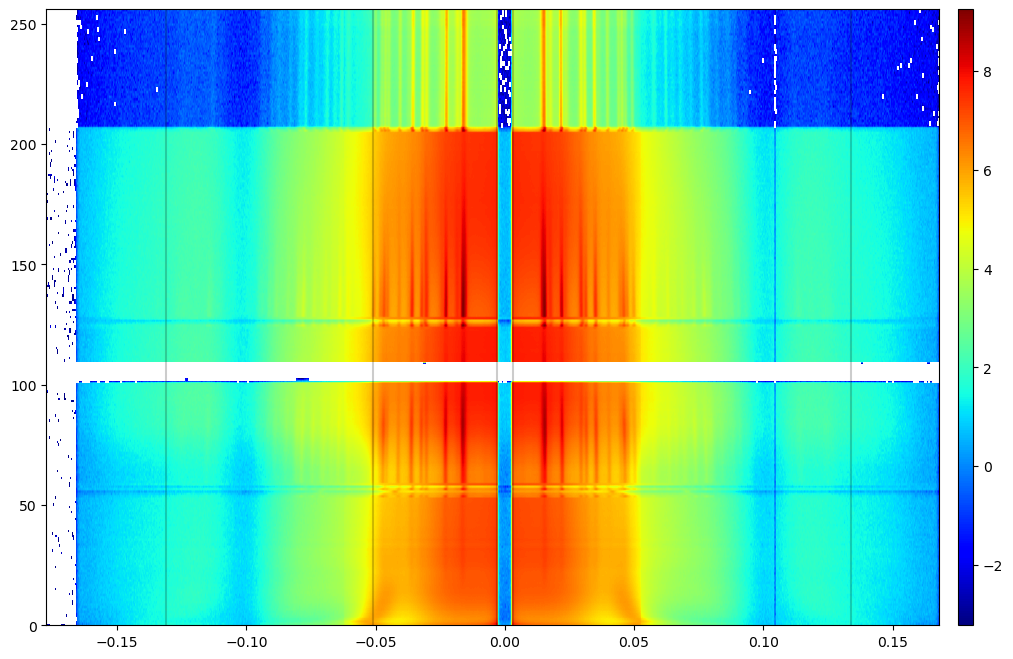

In [242]:
q_label = q_peaks #[1.278, 1.88, 2.219, 2.564, 2.905]; # Label the lines
flag_log = True

#protocol = 'circular_average'
protocol = list(exp.dict['analysis'].keys())[-1]


x_axis = exp.dict['analysis'][protocol]['q'] 
I_stack = exp.dict['analysis'][protocol]['I_stack']
if flag_log:
    I_stack = np.log(I_stack)
    
%matplotlib inline
plt.figure(2, figsize=(12,8)); plt.clf()
plt.imshow(I_stack, origin='lower', cmap='jet', extent = [np.min(x_axis), np.max(x_axis), 0, I_stack.shape[0]],  aspect='auto') #aspect='auto' 0.005
cbar = plt.colorbar(fraction=0.02, pad=0.02, aspect=40) 
     
print('q_label = {}'.format(q_label))
for q in q_label:
    plt.plot([q, q], [0, I_stack.shape[0]], 'k',  alpha=0.2)
    

##### - __Plot curves__

In [224]:
%matplotlib inline
plt.figure(1, figsize=(12,10)); plt.clf()
Nfiles = len(exp.dict['rawinfo']['filename'])
infile = exp.dict['rawinfo']['filename'][0]

qrange_plot = [0.1,1] ###
q_label = q_peaks #[1.278, 1.88, 2.219, 2.564, 2.905]; # Label the lines

cmap = mpl.colormaps['jet'] #viridis, jet, hsv, brg
colors = cmap(np.linspace(0.0, 1.0, Nfiles))
flag_log = 1

#sample_temperature_D = exp.dict['metadata']['sample_temperature_D']
sample_x = exp.dict['metadata']['sample_x']


### Plot
x_axis = exp.dict['analysis'][protocol]['q'] 
idx_min = int(np.argmin(np.abs(x_axis-qrange_plot[0])))
idx_max = int(np.argmin(np.abs(x_axis-qrange_plot[1])))

I_stack = exp.dict['analysis'][protocol]['I_stack']
spacing_plot = 0.7 #arbitrary

if flag_log:
    I_stack = np.log(I_stack)
    
    
for ii in np.arange(Nfiles):
    if 1: #sample_temperature_D[ii]>349.8:
        color = 'r'
        linestyle = None #'dashed' #dotted, dashed
    else:
        color = colors[ii]*0.8
        linestyle = None
        
    plt.plot(x_axis[idx_min:idx_max],I_stack[ii][idx_min:idx_max]+ii*spacing_plot, linestyle=linestyle, color=color, label=sample_temperature_D[ii])
    #plt.grid('minor')

for q in q_label:
    plt.plot([q, q], [min(I_stack[0])*0.8, max(I_stack[0])*1.2+Nfiles*spacing_plot], 'k',  alpha=0.2)

    
#plt.legend(fontsize=7, ncols=7, bbox_to_anchor=(1.01, 1.01)) 
plt.title('{}, N={}'.format(infile.split('raw')[-1], Nfiles))



KeyError: 'sample_x'

<Figure size 1200x1000 with 0 Axes>

#### &#9642; __Extract 0D feature & Plot 1D__

##### - __Load one curve for peak fitting__

{'fit_peaks_b': {'error': 0.09413989209026426, 'value': 2.0888519567908945},
 'fit_peaks_chi_squared': 0.0008281772494301456,
 'fit_peaks_d0': {'error': 2.5774710730629404e-05,
                  'value': 0.28343754761830214},
 'fit_peaks_d01': {'error': 2.5774710730629404e-05,
                   'value': 0.28343754761830214},
 'fit_peaks_grain_size': {'error': 0.5312951467161191,
                          'value': 24.90109012242812},
 'fit_peaks_grain_size1': {'error': 0.5312951467161191,
                           'value': 24.90109012242812},
 'fit_peaks_m': {'error': 0.04408469208421537, 'value': 1.5157061130800802},
 'fit_peaks_prefactor1': {'error': 0.018731353547661794,
                          'value': 1.0269505032681645},
 'fit_peaks_prefactor_total': 1.0269505032681645,
 'fit_peaks_qalpha': {'error': 0, 'value': 1.0},
 'fit_peaks_qp': {'error': 0, 'value': 0},
 'fit_peaks_sigma1': {'error': 0.0002147776383748681,
                      'value': 0.010066339514884573},
 'fit_peak

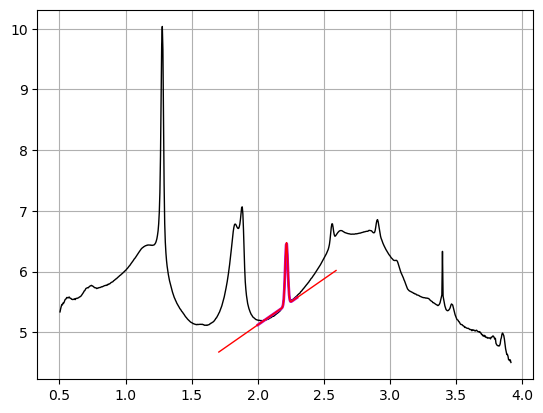

In [110]:
### Show one curve & do fitting
protocol = 'circular_average'

file_idx = 0
line_plot = DataLine(x = exp.dict['analysis'][protocol]['q'], y = exp.dict['analysis'][protocol]['I_stack'][file_idx])  

q0 = [2.15] #[2.64964595, 3.07210364] #[1.82, 1.86]
fit_range = [2, 2.3] #[2.5, 3.2] #[1.7, 1.95]

flag_log = True
if flag_log == 1:
    line_plot.y = np.log(line_plot.y)

## Fitting
run_args = { 'verbosity' : 3,
             #'fittype': 'voigt',
            }
results = {}
protocol = Protocols.fit_peaks()
lines = protocol._fit(line_plot, results, **run_args, q0=q0, num_curves=len(q0), fit_range=fit_range)

plt.figure(10); plt.clf()
for nn, line in enumerate(lines.lines):
        
    if nn==0: 
        plt.plot(line.x, line.y, 'k', linewidth=1, label=line.name)
        plt.title(line.name)
    elif nn==1:
        plt.plot(line.x, line.y, 'm', linewidth=2, label=line.name)
    else:
        plt.plot(line.x, line.y, 'r', linewidth=1, label=line.name)
        
    plt.grid()
    
pprint.pprint(lines.results)

##### - __Apply fitting for all__

In [127]:
protocol = 'circular_average'
q0 = [2.16] #[2.64964595, 3.07210364] #[1.82, 1.86]
fit_range = [2, 2.28] #[2.5, 3.2] #[1.7, 1.95]


## Fitting
run_args = { 'verbosity' : 3,
             #'fittype': 'voigt',
            }
p = Protocols.fit_peaks()
    

## Fitting all curves
peak_x1 = []
peak_x2 = []
peak_pre1 = []
t0 = time.time()
for ii in np.arange(Nfiles):
    line_plot = DataLine(x = exp.dict['analysis'][protocol]['q'], y = exp.dict['analysis'][protocol]['I_stack'][ii])  
    
    lines = p._fit(line_plot, results={}, **run_args, q0=q0, num_curves=len(q0), fit_range=fit_range)

    peak_x1.append(lines.results['fit_peaks_x_center1']['value'])
    #peak_x2.append(lines.results['fit_peaks_x_center2']['value'])
    peak_pre1.append(lines.results['fit_peaks_prefactor1']['value'])

print('Fitting took {:.0f}s\n'.format(time.time()-t0))

#Ts = exp.dict['metadata']['sample_temperature_D']
#scan_ids = exp.dict['rawinfo']['scan_id']


Fitting took 0s



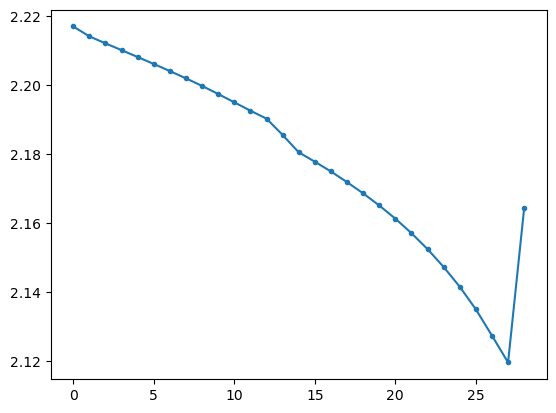

In [128]:
plt.plot(peak_x1, '.-')

In [136]:
exp.dict['analysis']['circular_average']['fit_peaks_x_center1'] = peak_x1
#exp.dict['analysis']['circular_average']['fit_peaks_x_center2'] = peak_x2
exp.show()


=== Overview of experiment dictionary ===
exp.dict['expinfo']
  -  keys = ['expname', 'det', 'beamline', 'folder', 'fn_patterns']
  -  key = expname, <class 'str'>, val = PBG_run1
  -  key = det, <class 'str'>, val = waxs
  -  key = beamline, <class 'str'>, val = cms
  -  key = folder, <class 'str'>, val = /nsls2/data/cms/legacy/xf11bm/data/2023_1/beamline/ETsai2/
  -  key = fn_patterns, <class 'list'>
exp.dict['rawinfo']
  -  keys = ['filename', 'time', 'clock', 'scan_id', 'uid', 'filenumber', 'series_measure', 'num_frames']
  -  key = filename, <class 'list'>, len(shape) = 29
  -  key = time, <class 'list'>, len(shape) = 29
  -  key = clock, <class 'list'>, len(shape) = 29
  -  key = scan_id, <class 'list'>, len(shape) = 29
  -  key = uid, <class 'list'>, len(shape) = 29
  -  key = filenumber, <class 'int'>, val = 29
  -  key = series_measure, <class 'bool'>, val = False
  -  key = num_frames, <class 'list'>, val = []
exp.dict['analysis']
  -  keys = ['cali', 'circular_average']
  -

In [30]:
#Convert list or dict to dataframe:
df_list = pd.DataFrame(peak_x1, columns=['peak_x1'])


__(Alternatively, other feature extration, e.g. q with max intensity)__

In [ ]:
### Get the q with max intensity within this range

protocol = 'circular_average'
y = []
for ii in np.arange(Nfiles):
    line_plot = DataLine(x = exp.dict['data'][protocol][str(ii)]['q'], y = exp.dict['data'][protocol][str(ii)]['I(q)'])  
    line_x = line_plot.x
    line_y = line_plot.y
    y.append(line_y[idx_min:idx_max])
    
qrange_plot = [1, 1.5] 


Ts = exp.dict['metadata']['sample_temperature_D']
scan_ids = exp.dict['expinfo']['scan_id']

idx_min = int(np.argmin(np.abs(x_axis-qrange_plot[0])))
idx_max = int(np.argmin(np.abs(x_axis-qrange_plot[1])))

x_axis = line_x
q_peakmax_list = []
data_show = []
for ii in np.arange(len(y)):
    line_y = y[ii]
    line_y_crop = line_y[idx_min:idx_max]
    line_x_crop = x_axis[idx_min:idx_max]
    q_peakmax = line_x_crop[np.argmax(line_y_crop)]
    q_peakmax_list.append(q_peakmax)
    data_show.append([Ts[ii], scan_ids[ii], q_peakmax])

df_line_s = pd.DataFrame(q_peakmax_list, columns=['I'])
df_show = pd.DataFrame(data_show, columns = ['RH', 'scan_id', 'q_peakmax'])

print(q_peakmax_list[0:5])

##### - __Compare three 1D curves__

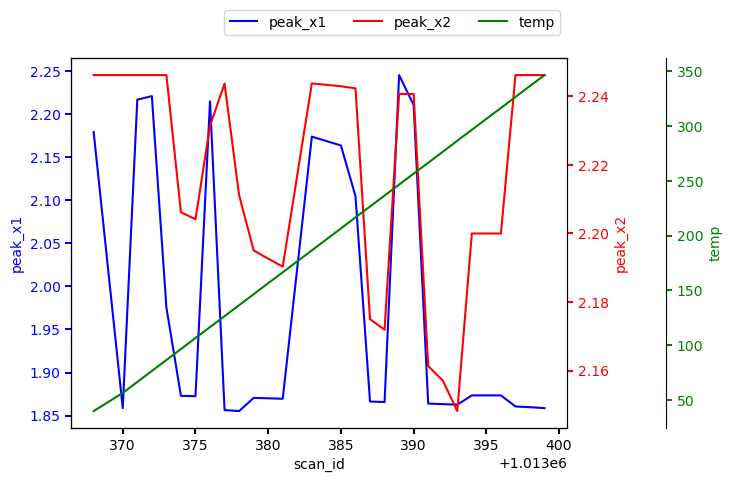

In [46]:
Ts = exp.dict['metadata']['sample_temperature_D']
scan_ids = exp.dict['rawinfo']['scan_id']


fig, ax = plt.subplots()
#fig.subplots_adjust(right=0.75)

twin1 = ax.twinx()
twin2 = ax.twinx()
twin2.spines.right.set_position(("axes", 1.2))


if 1:
    labels = ["peak_x1", "peak_x2", "temp"]
    p1, = ax.plot(scan_ids, peak_x1, "b-", label=labels[0])
    p2, = twin1.plot(scan_ids, peak_x2, "r-", label=labels[1])
    p3, = twin2.plot(scan_ids, Ts, "g-", label=labels[2])
else:
    p1, = ax.plot(scan_ids, q_peakmax_list, "b-", label="q")
    p2, = twin1.plot(scan_ids, np.array(Ts), "r-", label="Temperature")
    #p3, = twin2.plot([0, 1, 2], [50, 30, 15], "g-", label="Humidity")
    

#ax.set_xlim(0, 2)
#ax.set_ylim(0, 2)
#twin1.set_ylim(0, 4)
#twin2.set_ylim(1, 65)

ax.set_xlabel("scan_id")
ax.set_ylabel(labels[0])
twin1.set_ylabel(labels[1])
twin2.set_ylabel(labels[2])

ax.yaxis.label.set_color(p1.get_color())
twin1.yaxis.label.set_color(p2.get_color())
twin2.yaxis.label.set_color(p3.get_color())

tkw = dict(size=4, width=1.5)
ax.tick_params(axis='y', colors=p1.get_color(), **tkw)
twin1.tick_params(axis='y', colors=p2.get_color(), **tkw)
twin2.tick_params(axis='y', colors=p3.get_color(), **tkw)
ax.tick_params(axis='x', **tkw)

ax.legend(handles=[p1, p2, p3], ncols=3, bbox_to_anchor=(1, 1.15))
plt.show()

#### &#9642; __Extract 0d feature & Plot 2D map__

In [ ]:
### ROI
if 0:
    reduced_data = exp.dict['data']['roi']
    print('Len(reduced_data) = {}'.format(len(reduced_data)))
    print(reduced_data.keys())

    feature_list = []
    for ii in np.arange(0,len(reduced_data)):
        feature_list.append(reduced_data['stats_average'][ii])

In [481]:
### Angle

reduced_data = exp.dict['data']['linecut_angle']
print('Len(reduced_data) = {}'.format(len(reduced_data)))

x_pos = exp.dict['metadata']['sample_x']
y_pos = exp.dict['metadata']['sample_y']


feature_list = []
for ii in np.arange(0,len(reduced_data)):
    angle = reduced_data[str(ii)]['q']
    I = reduced_data[str(ii)]['I(q)']
    chi = angle[np.argmax(I)]
    feature_list.append(chi)


Len(reduced_data) = 3450


##### - __Plot scalar 2D mage__

(-2.5, 2.4000500000000002, -1.8000500000000001, 1.6000500000000002)

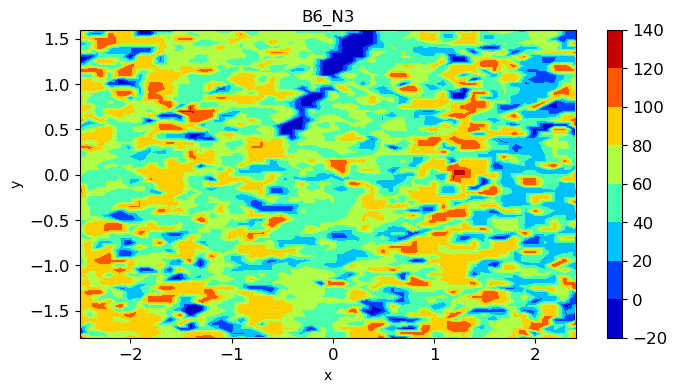

In [482]:
plt.figure(); plt.clf()

#plt.tripcolor(x_pos, y_pos, feature_list)  
plt.tricontourf(x_pos, y_pos, feature_list, cmap = 'jet') 

plt.colorbar()
plt.xlabel('x'); plt.ylabel('y')
plt.title(exp.dict['expname'])
plt.axis('equal')
plt.axis('tight')

#plt.plot(x_pos, y_pos, 'k.')

__Plot scalar image with interpolation__

(-2.5, 2.3999999999998956, -1.8000500000000001, 1.5999499999999274)

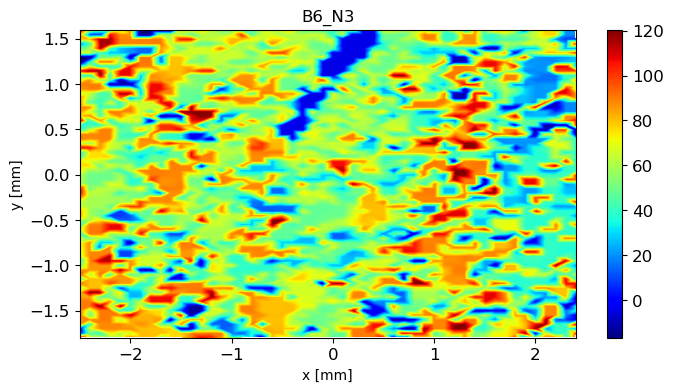

In [437]:
plot_interp = ['linear', 0.005] 
x_pos_fine, y_pos_fine, feature = Tools.interp_map(x_pos, y_pos, feature_list, plot_interp) 

plt.figure(); 
extent = (np.nanmin(x_pos_fine), np.nanmax(x_pos_fine), np.nanmin(y_pos_fine), np.nanmax(y_pos_fine))

plt.imshow(feature, extent=extent, origin='lower', cmap='jet') #, clim=[-180, 180])  
plt.colorbar()
plt.xlabel('x [mm]'); plt.ylabel('y [mm]')
plt.title(exp.dict['expname'])
plt.axis('equal')
plt.axis('tight')

##### - __Plot quiver__

In [438]:
u_list = []
v_list = []
chi_list = []
for chi in feature_list:
    u = np.cos(np.deg2rad(chi)) 
    v = np.sin(np.deg2rad(chi)) 
    u_list.append(u)
    v_list.append(v)
    chi_list.append(chi)

Text(0.5, 1.0, 'PBG_run1')

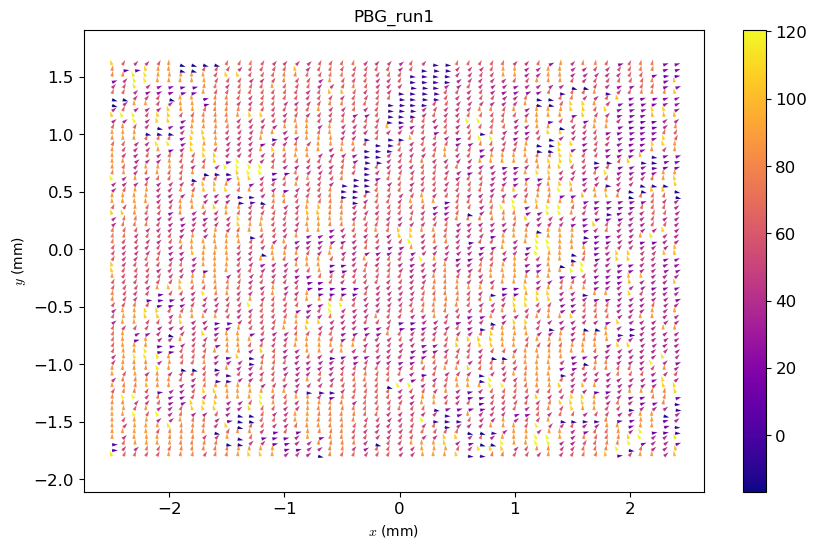

In [459]:
fig, ax = plt.subplots(figsize=[10, 6])

q = ax.quiver(x_pos, y_pos, u_list, v_list, chi_list, cmap = 'plasma') #,clim=[0,0.3])

#ax.set_xlim([-0.2,5])
#ax.set_ylim([-0.2,5])
ax.axis('equal')
ax.set_xlabel('$x$ (mm)'); ax.set_ylabel('$y$ (mm)')

cb = plt.colorbar(q)
plt.title(exp.dict['expname'])
# plt.savefig('SAXS mapping_quiver polt_colorbar.png', dpi = 600)


### __(5.2) Experiment__

#### &#9642; __Fitting for experiment__

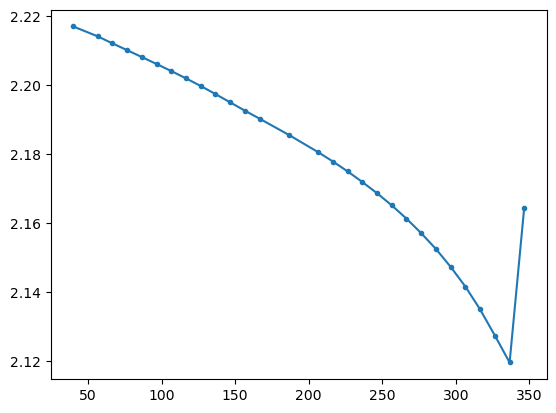

In [137]:
curve_1 = exp.dict['metadata']['sample_temperature_D']
curve_2 = exp.dict['analysis']['circular_average']['fit_peaks_x_center1']


plt.plot(curve_1, curve_2, '.-')
#plt.plot(curve_2)

In [165]:
from SciAnalysis import tools
from SciAnalysis.XSAnalysis.Data import *
#from SciAnalysis.XSAnalysis import Protocols
from SciAnalysis.CurveAnalysis.Data import *

#line_plot = DataLine(x = exp.dict['analysis'][protocol]['q'], y = exp.dict['analysis'][protocol]['I_stack'][file_idx])  
line_plot = DataLineStructuredSort(x = np.asarray(curve_1)*0.1, y = curve_2)


In [168]:
lm_result, fit_line, fit_line_extended = line_plot.fit_linear(line_plot, **run_args)


In [56]:
#lm_result

[2.22268847 2.21802335 2.21521305 2.21240274 2.20959243 2.20678212
 2.20394371 2.2011615  2.19835119 2.19554089 2.19273058 2.18989217
 2.18710996 2.18148934 2.17586873 2.17303031 2.17024811 2.1674378
 2.16462749 2.16181718 2.15903498 2.15622467 2.15338626 2.15057595
 2.14776564 2.14498343 2.14214502 2.13933471 2.13655251]


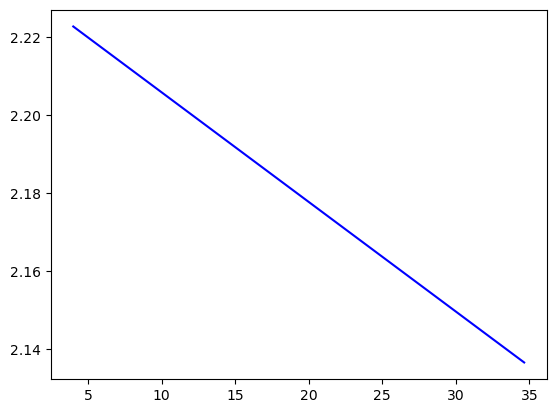

In [178]:
plt.plot(fit_line.x, fit_line.y, 'b')
#plt.plot(fit_line_extended.x, fit_line_extended.y, 'r:')
print(fit_line.y)

In [66]:
EXPR_DIR

'/nsls2/data/cms/legacy/xf11bm/data/2023_2/CKe/'

## 6. &#9733; Batch Processing 

Can be done in background with 'python runXS.py'

(If this section gets stuck for whatever reason, restart the kernal.)

In [ ]:
EXPR_DIR = '/nsls2/data/cms/legacy/xf11bm/data/2023_2/GDoerk3/'  ###CHANGE THIS

stitched = 0
pattern = '*'


if stitched==0:
    source_dir = EXPR_DIR+'/'+det+'/raw/' 
    output_dir = EXPR_DIR+'/'+det+'/analysis/'
else:
    source_dir = EXPR_DIR+'/'+det+'/stitched/'
    output_dir = EXPR_DIR+'/'+det+'/stitched_analysis/'

infiles = glob.glob(os.path.join(source_dir, pattern+'.tiff'))
infiles.sort()


mask_dir = SciAnalysis_PATH + '/SciAnalysis/XSAnalysis/masks/'
if stitched==0:
    mask = Mask(mask_dir+'Dectris/Pilatus800k_gaps-mask.png')
else:
    mask = Mask(mask_dir+'Dectris/Pilatus800k_vertical_gaps-mask.png')
mask.load(mask_dir+'NSLSII_11BM_CMS/Pilatus800k_CMS_badpixels-mask.png')


load_args = { 'calibration' : calibration, 
             'mask' : mask,
             #'rot180' : False,
             #'flip' : True, # PSCCD
             }
run_args = { 'verbosity' : 3,
            'rcParams': {'axes.labelsize': 25,
                            'xtick.labelsize': 18,
                            'ytick.labelsize': 18,
                            'xtick.major.pad': 5,
                            'ytick.major.pad': 5,
                            },
            }

process = Protocols.ProcessorXS(load_args=load_args, run_args=run_args)

# Examples:
#protocols = [ Protocols.circular_average_q2I(plot_range=[0, 0.2, 0, None]) ]
#protocols = [ Protocols.linecut_angle(q0=0.01687, dq=0.00455*1.5, show_region=False) ]
#protocols = [ Protocols.q_image(blur=1.0, bins_relative=0.5, plot_range=[-0.1, 3.0, 0, 3.0], _xticks=[0, 1.0, 2.0, 3.0], ztrim=[0.2, 0.01]) ]
#protocols = [ Protocols.qr_image(blur=1.0, bins_relative=0.5, plot_range=[-0.1, 3.0, 0, 3.0], _xticks=[0, 1.0, 2.0, 3.0], zmin=1010., ztrim=[None, 0.01]) ]
#protocols = [ Protocols.qr_image(blur=None, bins_relative=0.8, plot_range=[-0.1, 3.0, 0, 3.0], _xticks=[0, 1.0, 2.0, 3.0], ztrim=[0.38, 0.002], dezing_fill=True) ]
#protocols = [ Protocols.q_phi_image(bins_relative=0.25, plot_range=[0, 3.0, 0, +90]) ]
# Protocols.sector_average(angle=-70, dangle=25, show_region=False) 
# Protocols.qr_image(blur=None, colorbar=True, save_data=False, transparent=False, label_filename=True) 
# Protocols.linecut_q(chi0= 90+70, dq= .5, gridlines=True, label_filename=True, save_results = [ 'hdf5' ] )
# Protocols.HDF5(  save_results = [ 'hdf5' ] )
# Protocols.metadata_extract()

protocols = [
    #Protocols.HDF5(save_results=['hdf5'])
    #Protocols.calibration_check(show=False, AgBH=True, q0=1.076, dq=0.005, num_rings=10, ztrim=[0.2, 0.01], dpi=300) ,
    
    #Protocols.circular_average(ylog=True, plot_range=[None, None, None, None], dezing=True, gridlines=True, transparent=False, label_filename=True) ,
    #Protocols.thumbnails(crop=None, resize=0.5, cmap=cmap_vge, ztrim=[0.06, 0.001], zmin=1000.0) , # PSCCD
    
    #Protocols.thumbnails(crop=None, resize=0.5, cmap=cmap_vge, ztrim=[0.02, 0.001]) , # Pilatus800k
    #Protocols.thumbnails(name='thumbnails_jet', crop=None, ztrim=[0.06, 0.001]) , # Pilatus800k

    Protocols.qr_image(blur=None, colorbar=True, save_data=False, transparent=False, label_filename=True, plot_buffers = [0.1, 0.1, 0.1, 0.1]),    
    #Protocols.q_image(blur=None, colorbar=True, save_data=False, transparent=False, label_filename=True, plot_buffers = [0.1, 0.1, 0.1, 0.1], dpi=200) 
    #Protocols.linecut_qr(ylog=True, name='linecut_qr_qz0.03', qz=0.03, dq=0.02, show_region='save', label_filename=True, gridlines=True),
    
    ]

# Run
########################################
print('Processing {} infiles...'.format(len(infiles)))
process.run(infiles, protocols, output_dir=output_dir, force= 0)

print('Done!')

# Loop
########################################
# This is typically only used at the beamline (it loops forever, watching for new files).
#process.monitor_loop(source_dir=source_dir, pattern=pattern+'*.tiff', protocols=protocols, output_dir=output_dir, force=False)


Processing 98 infiles...
Running qr_image for AgBH_cali_2m_13.5kev_WAXSx-210_y22_x0.000_th0.000_10.00s_1135311_waxs


## 7. Stitching

(Originally in /nsls2/data/cms/legacy/xf11bm/software/StitchPilatus/)

In [62]:
import numpy as np
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt

from PIL import Image 

import sys, os
import glob

#### &#9642; __Pilatus2M__

In [59]:
#mask session
mask_folder = '/nsls2/data/cms/legacy/xf11bm/software/SciAnalysis/SciAnalysis/XSAnalysis/masks/'
mask = mask_folder + 'Dectris/Pilatus2M_gaps-mask.png'

mask1 = Image.open(mask).convert('I') # 'I' : 32-bit integer pixels
mask1_data = np.copy( np.asarray(mask1))
mask1_data = mask1_data/np.max(mask1_data)

mask_black = Image.new('L', (1475,1679), 'black')

#mask2
mask2_new = Image.new('I', (1475,1679), 'white')

#mask2 = mask1
mask2_cut = mask1.crop((0, 30 ,1475, 1679 ))
mask2_new.paste(mask2_cut)
mask2_black = mask_black.crop((0,  1679 -30 ,1475,1679 ))
mask2_new.paste(mask2_black, [0,  1679 -30])
mask2_new = mask2_new/np.max(mask2_new)

#mask3
mask3_new = Image.new('I', (1475,1679), 'white')

#mask3 = mask1
mask3_cut = mask1.crop((30 , 0, 1475, 1679))
mask3_new.paste(mask3_cut)
mask3_black = mask_black.crop((1475 -30 , 0, 1475, 1679 ))
mask3_new.paste(mask3_black, [1475 -30, 0])
mask3_new = mask3_new/np.max(mask3_new)


#mask4
mask4_new = Image.new('I', (1475,1679), 'white')

#mask3 = mask1
mask4_cut = mask1.crop((30 , 30, 1475, 1679))
mask4_new.paste(mask4_cut)
mask4_black1 = mask_black.crop((0,  1679 -30 ,1475,1679 ))
mask4_black2 = mask_black.crop((1475 -30 , 0, 1475, 1679 ))

mask4_new.paste(mask4_black1, [0,  1679 -30])
mask4_new.paste(mask4_black2, [1475 -30, 0])
mask4_new = mask4_new/np.max(mask4_new)

In [ ]:
img2_new = Image.new('I', (1475, 1679), 'white')
img3_new = Image.new('I', (1475, 1679), 'white')
img4_new = Image.new('I', (1475, 1679), 'white')
    
#Stitch functions
def stitch_4images(infile, infile2, infile3, infile4):

    #load images to data array
    img = Image.open(infile).convert('I') # 'I' : 32-bit integer pixels
    data = np.copy( np.asarray(img) )
    img2 = Image.open(infile2[0]).convert('I') # 'I' : 32-bit integer pixels
    data2 = np.copy( np.asarray(img2) )    
    img3 = Image.open(infile3[0]).convert('I') # 'I' : 32-bit integer pixels
    data3 = np.copy( np.asarray(img3) )    
    img4 = Image.open(infile4[0]).convert('I') # 'I' : 32-bit integer pixels
    data4 = np.copy( np.asarray(img4) )    

    
    #move the data to the original position
    
    img2_cut = img2.crop((0, 30 ,1475, 1679))
    img2_new.paste(img2_cut)
    data2_data = np.copy( np.asarray(img2_new) )
    img3_cut = img3.crop((30, 0 ,1475, 1679))
    img3_new.paste(img3_cut)
    data3_data = np.copy( np.asarray(img3_new) )
    img4_cut = img4.crop((30, 30 ,1475, 1679))
    img4_new.paste(img4_cut)
    data4_data = np.copy( np.asarray(img4_new) )

    #merge masks
    data1_new= data*mask1_data
    data2_new = data2_data*mask2_new
    data3_new= data3_data*mask3_new
    data4_new = data4_data*mask4_new

    
    #data output
    final_data = (data1_new+data2_new+data3_new+data4_new)/(mask1_data+mask2_new+mask3_new+mask4_new)
#    final_data = (data1_new+data2_new+data3_new)/(mask1_data+mask2_new+mask3_new)
#    final_data = (data1_new+data4_new)/(mask1_data+mask4_new)
    
    final_img = Image.fromarray((final_data).astype(np.uint32))

    return final_img    
    
#only two positions for ygaps
def stitch_2images(infile, infile2):

    #load images to data array
    img = Image.open(infile).convert('I') # 'I' : 32-bit integer pixels
    data = np.copy( np.asarray(img) )
    
    if infile2 != []:
        img2 = Image.open(infile2[0]).convert('I') # 'I' : 32-bit integer pixels
#         img2 = Image.open(infile2).convert('I'|) # 'I' : 32-bit integer pixels
        data2 = np.copy( np.asarray(img2) )    

        #move the data to the original position    
        img2_cut = img2.crop((0, 30 ,1475, 1679))
        img2_new.paste(img2_cut)
        data2_data = np.copy( np.asarray(img2_new) )

        #merge masks
        data1_new= data*mask1_data
        data2_new = data2_data*mask2_new

        #data output
        final_data = (data1_new+data2_new)/(mask1_data+mask2_new)
    #    plt.imshow(np.log(final_data), cmap="hot");plt.colorbar();plt.clim(-1, 3)
    else:
        final_data = data*mask1_data

    final_data[np.isnan(final_data)]=-2
    final_img = Image.fromarray((final_data).astype(np.uint32))
#     infile_done = 'stitched/{}_{}.tiff'.format(infile[2:-5],'stitched')
    
#     final_img.save(infile_done)  
    return final_img

def prRed(skk): print("\033[91m {}\033[00m" .format(skk)) 

def stitch_2images_folder(folder, infiles=None, interval=1, force=False):
    source_dir = folder + '/saxs/raw/'#'/maxs/raw/'   
    output_dir = folder + '/saxs/stitched/'#'/maxs/stitched/'
    if os.path.isdir(output_dir)==False:
        os.mkdir(output_dir)
    if infiles==None:
        infiles = glob.glob(os.path.join(source_dir, '*pos1*.tiff'))
    else:
        infiles = glob.glob(os.path.join(source_dir, '*{}*pos1*.tiff'.format(infiles)))
    
    infiles.sort()
    processed_count = 0
    error_count = 0
    files_with_errors = ""
    for infile in infiles:
        print(infile)
        infile_filename = infile.split('/')[-1]
        infile_name = infile_filename.split('_')
        infile_name_full = infile_filename.split('_pos1_')
        print(infile_name[-2])
       # print(infile_name)
        for ct, value in enumerate(infile.split('_')):
            if value == 'pos1':
                number = int(infile_name[-2])
                infile2 = glob.glob(os.path.join(source_dir, '{}*pos2*{}*.tiff'.format(infile_name_full[0],str(number+interval) )))
                print("Matched to       :  {}".format(infile2))   
#                 print('TEST: filename = {}'.format(infile_name_full[0]))
                

        if infile2 != []:
            infile_done = output_dir +'{}_{}.tiff'.format(infile_filename[:-5],'stitched')
            if os.path.isfile(infile_done)==False or force==True:
                final_data = stitch_2images(infile, infile2)
                processed_count += 1
                final_data.save(infile_done)
        else:
            files_with_errors += "\r\n"+" {}".format(infile)
            error_count += 1
            #return 
            prRed('Error: The stitching files {} are not valid.'.format(infile))
        
         
        
    print("Processed {} files".format(processed_count))
    print("Errors on  {} files".format(error_count))
    print("    Those errors were on:")
    print(files_with_errors)            

def stitch_2images_folderlist(folder, infiles=None, interval=1, force=False):
    #doesnot care the infile name in pos2 images
    
    source_dir = folder + '/saxs/raw/'#'/maxs/raw/'   
    output_dir = folder + '/saxs/stitched/'#'/maxs/stitched/'

    
    source_dir = folder + '/saxs/raw/'
    output_dir = folder + '/saxs/stitched/'#'/maxs/stitched/'
    if os.path.isdir(output_dir)==False:
        os.mkdir(output_dir)
    if infiles==None:
        infiles = glob.glob(os.path.join(source_dir, '*pos1*.tiff'))
    else:
        infiles = glob.glob(os.path.join(source_dir, '*{}*pos1*.tiff'.format(infiles)))
    
    infiles.sort()
    processed_count = 0
    error_count = 0
    files_with_errors = ""
    for infile in infiles:
        print(infile)
        infile_filename = infile.split('/')[-1]
        infile_name = infile_filename.split('_')
        infile_name_full = infile_filename.split('_pos1_')
        print(infile_name[-2])
       # print(infile_name)
        for ct, value in enumerate(infile.split('_')):
            if value == 'pos1':
                number = int(infile_name[-2])
                infile2 = glob.glob(os.path.join(source_dir, '*pos2*{}*.tiff'.format(str(number+interval) )))
                print("Matched to       :  {}".format(infile2))   
#                 print('TEST: filename = {}'.format(infile_name_full[0]))
                

        if infile2 != []:
            infile_done = output_dir +'{}_{}.tiff'.format(infile_filename[:-5],'stitched')
            if os.path.isfile(infile_done)==False or force==True:
                final_data = stitch_2images(infile, infile2)
                processed_count += 1
                final_data.save(infile_done)
        else:
            files_with_errors += "\r\n"+" {}".format(infile)
            error_count += 1
            #return 
            prRed('Error: The stitching files {} are not valid.'.format(infile))
        
         
        
    print("Processed {} files".format(processed_count))
    print("Errors on  {} files".format(error_count))
    print("    Those errors were on:")
    print(files_with_errors)            
def stitch_4images_folder(folder, infiles=None, interval=1, force=False):
    source_dir = folder + '/saxs/raw/'   
    output_dir = folder + '/saxs/stitched/'
    if os.path.isdir(source_dir)==False:
        return
    
    if os.path.isdir(output_dir)==False:
        os.mkdir(output_dir)

    if infiles==None:
        infiles = glob.glob(os.path.join(source_dir, '*pos1*.tiff'))
    else:
        infiles = glob.glob(os.path.join(source_dir, '*{}*pos1*.tiff'.format(infiles)))

    infiles.sort()
    processed_count = 0
    error_count = 0
    files_with_errors = ""
    
    for infile in infiles:
        print(infile)
        infile_filename = infile.split('/')[-1]
        infile_name = infile_filename.split('_')
        infile_name_full = infile_filename.split('_pos1_')
        print(infile_name[-2])
        for ct, value in enumerate(infile.split('_')):
            if value == 'pos1':
                number = int(infile_name[-2])
                infile2 = glob.glob(os.path.join(source_dir, '{}*pos2*{}*.tiff'.format(infile_name_full[0],str(number+interval*1) )))
                infile3 = glob.glob(os.path.join(source_dir, '{}*pos3*{}*.tiff'.format(infile_name_full[0],str(number+interval*3) )))
                infile4 = glob.glob(os.path.join(source_dir, '{}*pos4*{}*.tiff'.format(infile_name_full[0],str(number+interval*2) )))
                print(infile2)   

        if infile2 != [] and  infile3 != [] and  infile4 != []:
            infile_done = output_dir +'{}_{}.tiff'.format(infile_filename[:-5],'stitched')
            if os.path.isfile(infile_done)==False or force==True:
                final_data = stitch_4images(infile, infile2, infile3, infile4)
                processed_count += 1
                final_data.save(infile_done)
      

        else:
            files_with_errors += "\r\n"+" {}".format(infile)
            error_count += 1
            #return 
            prRed('Error: The stitching files {} are not valid.'.format(infile))
            
def stitch_2images_filelist(folder, infiles=None, interval=1, force=False):
    source_dir = folder + '/saxs/raw/'   
    output_dir = folder + '/saxs/stitched/'
#     output_dir = folder + '/waxs/stitched/2images'

    pos1_filelist = folder + 'SAXS_pos1_list.csv'
    pos2_filelist = folder + 'SAXS_pos2_list.csv'
    if os.path.isdir(output_dir)==False:
        os.mkdir(output_dir)
        
    with open(pos1_filelist) as file:
        pos1_lines = file.readlines()    
    with open(pos2_filelist) as file:
        pos2_lines = file.readlines()    
    
    for ii in range(len(pos2_lines)):
        
        infile = folder+pos1_lines[ii].rstrip()
        infile2 = folder+pos2_lines[ii].rstrip()

        print(infile)
        
        infile_done = output_dir +'{}_{}.tiff'.format(pos1_lines[ii].split('/')[-1].rstrip()[:-5],'stitched')
        if os.path.isfile(infile_done)==False or force==True:
            final_data = stitch_2images(infile, infile2)
#             processed_count += 1
            final_data.save(infile_done) 

            print("Fist data at pos1:  {}".format(infile))   
            print("Matched to       :  {}".format(infile2))   
        else:
            
            print('the file has been generated')

##### __Stitch ygap__

In [ ]:
source_dir = '/nsls2/data/cms/legacy/xf11bm/data/2023_2/GDoerk2/'
stitch_2images_folder(folder=source_dir, interval=5)


#### &#9642; __Pilatus800k__

In [4]:
mask_folder = '/nsls2/data/cms/legacy/xf11bm/software/SciAnalysis/SciAnalysis/XSAnalysis/masks/'
mask = mask_folder + 'Dectris/Pilatus800k_gaps-mask.png'
# mask = mask_folder + 'Dectris/Pilatus800_current-mask_extrawideblock.png'

mask1 = Image.open(mask).convert('I') # 'I' : 32-bit integer pixels
mask1_data = np.copy( np.asarray(mask1))
mask1_data = mask1_data/np.max(mask1_data)

mask_black = Image.new('L', (981,1043), 'black')

#mask2
mask2_new = Image.new('I', (981,1043), 'white')

#mask2 = mask1
mask2_cut = mask1.crop((0, 30 ,981, 1043 ))
mask2_new.paste(mask2_cut)
mask2_black = mask_black.crop((0,  1043 -30 ,981,1043 ))
mask2_new.paste(mask2_black, [0,  1043 -30])
mask2_new = mask2_new/np.max(mask2_new)

#mask3
mask3_new = Image.new('I', (981 ,1043), 'white')

#mask3 = mask1
# mask3_cut = mask1.crop((30 , 0, 981, 1043))
# mask3_new.paste(mask3_cut)
# mask3_black = mask_black.crop((981 -30 , 0, 981, 1043 ))
# mask3_new.paste(mask3_black, [981 -30, 0])
# mask3_new = mask3_new/np.max(mask3_new)

mask3_cut = mask1.crop((0 , 0, 981-30, 1043))
mask3_black = mask_black.crop((0 , 0, 30, 1043 ))
mask3_new.paste(mask3_black)
mask3_new.paste(mask3_cut, [30, 0])
mask3_new = mask3_new/np.max(mask3_new)

#mask4
mask4_new = Image.new('I', (981,1043), 'white')

#mask3 = mask1
mask4_cut = mask1.crop((0 , 30, 981-30, 1043))
mask4_black1 = mask_black.crop((0,  1043 -30 ,981,1043 ))
mask4_black2 = mask_black.crop((0 , 0, 30, 1043 ))
mask4_new.paste(mask4_black2)
mask4_new.paste(mask4_black1, [0,  1043 -30])
mask4_new.paste(mask4_cut, [30, 0])
mask4_new = mask4_new/np.max(mask4_new)

img2_new = Image.new('I', (981, 1043), 'white')
img3_new = Image.new('I', (981, 1043), 'white')
img4_new = Image.new('I', (981, 1043), 'white')
    
#Stitch functions
def stitch_4images(infile, infile2, infile3, infile4):

    if infile2 != [] and infile3 != [] and infile4 != []:
        #load images to data array
        img = Image.open(infile).convert('I') # 'I' : 32-bit integer pixels
        data = np.copy( np.asarray(img) )
        img2 = Image.open(infile2[0]).convert('I') # 'I' : 32-bit integer pixels
        data2 = np.copy( np.asarray(img2) )    
        img3 = Image.open(infile3[0]).convert('I') # 'I' : 32-bit integer pixels
        data3 = np.copy( np.asarray(img3) )    
        img4 = Image.open(infile4[0]).convert('I') # 'I' : 32-bit integer pixels
        data4 = np.copy( np.asarray(img4) )    

        #move the data to the original position

        img2_cut = img2.crop((0, 30 ,981, 1043))
        img2_new.paste(img2_cut)
        data2_data = np.copy( np.asarray(img2_new) )
        img3_cut = img3.crop((0, 0 ,981-30, 1043))
        img3_black = mask_black.crop((0 , 0, 30, 1043 ))
        img3_new.paste(img3_black)
        img3_new.paste(img3_cut, [30, 0])
        data3_data = np.copy( np.asarray(img3_new) )

        img4_cut = img4.crop((0, 30 ,981-30, 1043))
        img4_black1 = mask_black.crop((0,  1043-30 ,981, 1043 ))
        img4_black2 = mask_black.crop((0 , 0, 30, 1043 ))
        img4_new.paste(img4_black2)
        img4_new.paste(img4_black1, [0,  1043 -30])
        img4_new.paste(img4_cut, [30, 0])
        data4_data = np.copy( np.asarray(img4_new) )

        #merge masks
        data1_new= data*mask1_data
        data2_new = data2_data*mask2_new
        data3_new= data3_data*mask3_new
        data4_new = data4_data*mask4_new


        #data output
        final_data = (data1_new+data2_new+data3_new+data4_new)/(mask1_data+mask2_new+mask3_new+mask4_new)
    #     final_data = (data1_new+data2_new+data3_new)/(mask1_data+mask2_new+mask3_new)
    #     final_data = (data1_new+data4_new)/(mask1_data+mask4_new)

    #    plt.imshow(np.log(final_data), cmap="hot");plt.colorbar();plt.clim(-1, 3)
#     else:
#         final_data = data*mask1_data
    
    final_data[np.isnan(final_data)]=-2
    final_img = Image.fromarray((final_data).astype(np.uint32))
    return final_img
    
def stitch_3images(infile, infile2, infile3):

    if infile2 != [] and infile3 != [] :
        #load images to data array
        img = Image.open(infile).convert('I') # 'I' : 32-bit integer pixels
        data = np.copy( np.asarray(img) )
        img2 = Image.open(infile2[0]).convert('I') # 'I' : 32-bit integer pixels
        data2 = np.copy( np.asarray(img2) )    
        img3 = Image.open(infile3[0]).convert('I') # 'I' : 32-bit integer pixels
        data3 = np.copy( np.asarray(img3) )    
#         img4 = Image.open(infile4[0]).convert('I') # 'I' : 32-bit integer pixels
#         data4 = np.copy( np.asarray(img4) )    

        #move the data to the original position

        img2_cut = img2.crop((0, 30 ,981, 1043))
        img2_new.paste(img2_cut)
        data2_data = np.copy( np.asarray(img2_new) )
        img3_cut = img3.crop((0, 0 ,981-30, 1043))
        img3_black = mask_black.crop((0 , 0, 30, 1043 ))
        img3_new.paste(img3_black)
        img3_new.paste(img3_cut, [30, 0])
        data3_data = np.copy( np.asarray(img3_new) )

#         img4_cut = img4.crop((0, 30 ,981-30, 1043))
#         img4_black1 = mask_black.crop((0,  1043-30 ,981, 1043 ))
#         img4_black2 = mask_black.crop((0 , 0, 30, 1043 ))
#         img4_new.paste(img4_black2)
#         img4_new.paste(img4_black1, [0,  1043 -30])
#         img4_new.paste(img4_cut, [30, 0])
#         data4_data = np.copy( np.asarray(img4_new) )

        #merge masks
        data1_new= data*mask1_data
        data2_new = data2_data*mask2_new
        data3_new= data3_data*mask3_new
#         data4_new = data4_data*mask4_new


        #data output
        final_data = (data1_new+data2_new+data3_new)/(mask1_data+mask2_new+mask3_new)
    #     final_data = (data1_new+data2_new+data3_new)/(mask1_data+mask2_new+mask3_new)
    #     final_data = (data1_new+data4_new)/(mask1_data+mask4_new)

    #    plt.imshow(np.log(final_data), cmap="hot");plt.colorbar();plt.clim(-1, 3)
#     else:
#         final_data = data*mask1_data
    
    final_data[np.isnan(final_data)]=-2
    final_img = Image.fromarray((final_data).astype(np.uint32))
    return final_img

#only two positions for ygaps
def stitch_2images(infile, infile2, show_region=False):

    if type(infile)==list:
        infile = infile[0]
    if type(infile2)==list:
        infile2 = infile2[0]
    #load images to data array
    img = Image.open(infile).convert('I') # 'I' : 32-bit integer pixels
    data = np.copy( np.asarray(img) )
    if infile2 != []:
        img2 = Image.open(infile2).convert('I') # 'I' : 32-bit integer pixels
        data2 = np.copy( np.asarray(img2) )    

        #move the data to the original position    
        img2_cut = img2.crop((0, 30 ,981, 1043))
        img2_new.paste(img2_cut)
        data2_data = np.copy( np.asarray(img2_new) )

        #merge masks
        data1_new= data*mask1_data
        data2_new = data2_data*mask2_new

        #data output
        final_data = (data1_new+data2_new)/(mask1_data+mask2_new)
    else:
        final_data = data*mask1_data

    final_data[np.isnan(final_data)]=-2
    
    if show_region==True:
        ax1 = plt.subplot(221)
        ax2 = plt.subplot(222)
        ax3 = plt.subplot(223)
        ax1 = plt.imshow(np.log(final_data), cmap="hot");plt.colorbar();plt.clim(-1, 3)
        ax2 = plt.imshow(np.log(data2_data), cmap="hot");plt.colorbar();plt.clim(-1, 3)
        ax3 = plt.imshow(np.log(data), cmap="hot");plt.colorbar();plt.clim(-1, 3)
    
    final_img = Image.fromarray((final_data).astype(np.uint32))
    return final_img

def stitch_4images_folder(folder, infiles=None, interval=1, overwrite=False):
    source_dir = folder + '/waxs/raw/'   
    output_dir = folder + '/waxs/stitched/'
#     output_dir = folder + '/waxs/stitched/'
    if os.path.isdir(output_dir)==False:
        os.mkdir(output_dir)

    if infiles==None:
        infiles = glob.glob(os.path.join(source_dir, '*pos1*.tiff'))
    else:
        infiles = glob.glob(os.path.join(source_dir, '*{}*pos1*.tiff'.format(infiles)))
    infiles.sort()
    processed_count = 0
    error_count = 0
    files_with_errors = ""
    for infile in infiles:
        print(infile)
        infile_filename = infile.split('/')[-1]
        infile_name = infile_filename.split('_')
        #print(infile_name)
        for ct, value in enumerate(infile.split('_')):
            if value == 'pos1':
                number = int(infile_name[-2])
                infile2 = glob.glob(os.path.join(source_dir, '{}*pos2*{}*.tiff'.format(infile_name[0],str(number+interval*1) )))
                infile3 = glob.glob(os.path.join(source_dir, '{}*pos3*{}*.tiff'.format(infile_name[0],str(number+interval*3) )))
                infile4 = glob.glob(os.path.join(source_dir, '{}*pos4*{}*.tiff'.format(infile_name[0],str(number+interval*2) )))
                print(infile2)   

        if infile2 != [] and  infile3 != [] and  infile4 != []:
            #final_data = test_stitch_2images(infile, infile2)#, infile3, infile4)
            final_data = stitch_4images(infile, infile2, infile3, infile4)
            processed_count += 1
            infile_done = output_dir +'{}_{}.tiff'.format(infile_filename[:-5],'stitched')
            
#             if infile_done is valid:
#                 overwrite==True
            final_data.save(infile_done) 
        else:
            files_with_errors += "\r\n"+" {}".format(infile)
            error_count += 1
            #return 
            prRed('Error: The stitching files {} are not valid.'.format(infile))
#         infile_done = output_dir + '{}_{}.tiff'.format(infile_filename[:-5],'stitched')
#         final_data.save(infile_done)    

def stitch_3images_folder(folder, infiles=None, interval=1):
    source_dir = folder  + '/waxs/raw/'    
    output_dir = folder + '/waxs/stitched/3images'
#     output_dir = folder + '/waxs/stitched/'
    if os.path.isdir(output_dir)==False:
        os.mkdir(output_dir)

    if infiles==None:
        infiles = glob.glob(os.path.join(source_dir, '*pos1*.tiff'))
    else:
        infiles = glob.glob(os.path.join(source_dir, '*{}*pos1*.tiff'.format(infiles)))
    infiles.sort()
    processed_count = 0
    error_count = 0
    files_with_errors = ""
    for infile in infiles:
        print(infile)
        infile_filename = infile.split('/')[-1]
        infile_name = infile_filename.split('_')
        #print(infile_name)
        for ct, value in enumerate(infile.split('_')):
            if value == 'pos1':
                number = int(infile_name[-2])
                infile2 = glob.glob(os.path.join(source_dir, '{}*pos2*{}*.tiff'.format(infile_name[0],str(number+interval*1) )))
                infile3 = glob.glob(os.path.join(source_dir, '{}*pos3*{}*.tiff'.format(infile_name[0],str(number+interval*2) )))
#                 infile4 = glob.glob(os.path.join(source_dir, '{}*pos4*{}*.tiff'.format(infile_name[0],str(number+2) )))
                print(infile2)   

        if infile2 != [] and  infile3 != []:
            #final_data = test_stitch_2images(infile, infile2)#, infile3, infile4)
            final_data = stitch_3images(infile, infile2, infile3)
            processed_count += 1
            infile_done = output_dir +'{}_{}.tiff'.format(infile_filename[:-5],'stitched')
            final_data.save(infile_done) 
            
        else:
            files_with_errors += "\r\n"+" {}".format(infile)
            error_count += 1
            #return 
            prRed('Error: The stitching files {} are not valid.'.format(infile))

#         infile_done = output_dir + '{}_{}.tiff'.format(infile_filename[:-5],'stitched')
#         final_data.save(infile_done)   

def prRed(skk): print("\033[91m {}\033[00m" .format(skk)) 

#stitched data at fixed interval, doesnot match the file names
def stitch_2images_folder_brutal(folder, infiles=None, interval=1, force=False):
    source_dir = folder + '/waxs/raw/'   
    output_dir = folder + '/waxs/stitched/'
#     output_dir = folder + '/waxs/stitched/2images'
    if os.path.isdir(output_dir)==False:
        os.mkdir(output_dir)
    if infiles==None:
        infiles = glob.glob(os.path.join(source_dir, '*pos1*.tiff'))
    else:
        infiles = glob.glob(os.path.join(source_dir, '*{}*pos1*.tiff'.format(infiles)))
    
    infiles.sort()
    processed_count = 0
    error_count = 0
    files_with_errors = ""
    for infile in infiles:
        print(infile)
        infile_filename = infile.split('/')[-1]
        infile_name = infile_filename.split('_')
        infile_name_full = infile_filename.split('_pos1_')
        print(infile_name[-2])
       # print(infile_name)
        for ct, value in enumerate(infile.split('_')):
            if value == 'pos1':
                number = int(infile_name[-2])
                infile2 = glob.glob(os.path.join(source_dir, '*pos2*{}*.tiff'.format(str(number+interval) )))
                print("Matched to       :  {}".format(infile2))   

        if infile2 != []:
            
            infile_done = output_dir +'{}_{}.tiff'.format(infile_filename[:-5],'stitched')
            if os.path.isfile(infile_done)==False or force==True:
                final_data = stitch_2images(infile, infile2)
                processed_count += 1
                final_data.save(infile_done) 
            else:
                print('the file has been generated')
        
        else:
            files_with_errors += "\r\n"+" {}".format(infile)
            error_count += 1
            #return 
            prRed('Error: The stitching files {} are not valid.'.format(infile))
        
        
# #     print("Processed {} files".format(processed_count))
#     print("Errors on  {} files".format(error_count))
#     print("    Those errors were on:")
#     print(files_with_errors)
    

    
def stitch_2images_folder(folder, det='waxs', infiles=None, match_th=1, interval=1, force=False):
    source_dir = folder + '/' + det+ '/raw/'   
    output_dir = folder + '/' + det+ '/stitched/'
#     output_dir = folder + '/waxs/stitched/2images'
    if os.path.isdir(output_dir)==False:
        os.mkdir(output_dir)
    if infiles==None:
        infiles = glob.glob(os.path.join(source_dir, '*pos1*.tiff'))
    else:
        infiles = glob.glob(os.path.join(source_dir, '*{}*pos1*.tiff'.format(infiles)))
    
    infiles.sort()
    processed_count = 0
    error_count = 0
    files_with_errors = ""
    for infile in infiles:
        print(infile)
        infile_filename = infile.split('/')[-1]
        infile_name = infile_filename.split('_')
        infile_name_full = infile_filename.split('_pos1_')
        print(infile_name[-2])
        if match_th == 1:
            x = infile.split('_th')
            th = float(x[1].split('_')[0])
            print(th)
            
       # print(infile_name)
        for ct, value in enumerate(infile.split('_')):
            if value == 'pos1':
                number = int(infile_name[-2])
                if match_th==1:
                    infile2 = glob.glob(os.path.join(source_dir, '{}*pos2*{}*{}*.tiff'.format(infile_name_full[0],th,str(number+interval) )))
                else:
                    infile2 = glob.glob(os.path.join(source_dir, '{}*pos2*{}*.tiff'.format(infile_name_full[0],str(number+interval) )))
                print("Matched to       :  {}".format(infile2))   

        if infile2 != []:
            
            infile_done = output_dir +'{}_{}.tiff'.format(infile_filename[:-5],'stitched')
            if os.path.isfile(infile_done)==False or force==True:
                final_data = stitch_2images(infile, infile2)
                processed_count += 1
                final_data.save(infile_done) 
            else:
                print('the file has been generated')
        
        else:
            files_with_errors += "\r\n"+" {}".format(infile)
            error_count += 1
            #return 
            prRed('Error: The stitching files {} are not valid.'.format(infile))
        
        
    print("Processed {} files".format(processed_count))
    print("Errors on  {} files".format(error_count))
    print("    Those errors were on:")
    print(files_with_errors)


    #load two filelists, by default names as 'WAXS_pos1_list.csv' and 'WAXS_pos2_list.csv'
def stitch_2images_filelist(folder, infiles=None, interval=1, force=False):
    source_dir = folder + '/waxs/raw/'   
    output_dir = folder + '/waxs/stitched/'
#     output_dir = folder + '/waxs/stitched/2images'

    pos1_filelist = folder + 'WAXS_pos1_list.csv'
    pos2_filelist = folder + 'WAXS_pos2_list.csv'
    if os.path.isdir(output_dir)==False:
        os.mkdir(output_dir)
        
    with open(pos1_filelist) as file:
        pos1_lines = file.readlines()    
    with open(pos2_filelist) as file:
        pos2_lines = file.readlines()    
    
    for ii in range(len(pos2_lines)):
        
        infile = folder+pos1_lines[ii].rstrip()
        infile2 = folder+pos2_lines[ii].rstrip()

        infile_done = output_dir +'{}_{}.tiff'.format(pos1_lines[ii].split('/')[-1].rstrip()[:-5],'stitched')
        if os.path.isfile(infile_done)==False or force==True:
            final_data = stitch_2images(infile, infile2)
#             processed_count += 1
            final_data.save(infile_done) 

            print("Fist data at pos1:  {}".format(infile))   
            print("Matched to       :  {}".format(infile2))   
        else:
            
            print('the file has been generated')
        
        
        
        
#     print("Processed {} files".format(processed_count))
#     print("Errors on  {} files".format(error_count))
#     print("    Those errors were on:")
#     print(files_with_errors)
    
    
def stitch_2images_folder_pos2(folder, infiles=None, interval=1, force=False):
    source_dir = folder + '/waxs/raw/'   
    output_dir = folder + '/waxs/stitched/'
#     output_dir = folder + '/waxs/stitched/2images'
    if os.path.isdir(output_dir)==False:
        os.mkdir(output_dir)
    if infiles==None:
        infiles = glob.glob(os.path.join(source_dir, '*pos2*.tiff'))
    else:
        infiles = glob.glob(os.path.join(source_dir, '*{}*pos2*.tiff'.format(infiles)))
    
    infiles.sort()
    processed_count = 0
    error_count = 0
    files_with_errors = ""
    for infile in infiles:
        print(infile)
        infile_filename = infile.split('/')[-1]
        infile_name = infile_filename.split('_')
        infile_name_full = infile_filename.split('_pos2_')
        print(infile_name[-2])
       # print(infile_name)
        for ct, value in enumerate(infile.split('_')):
            if value == 'pos2':
                number = int(infile_name[-2])
                infile1 = glob.glob(os.path.join(source_dir, '{}*pos1*{}*.tiff'.format(infile_name_full[0],str(number-interval) )))
                 

        if infile1 != []:
            
            infile_done = output_dir +'{}_{}.tiff'.format(infile_filename[:-5],'stitched')
            print("Matched to       :  {}".format(infile1))  
            print("Stitched to       :  {}".format(infile_done))  
            print(infile1)
            print(infile)
            if os.path.isfile(infile_done)==False or force==True:
                final_data = stitch_2images(infile1, infile)
                processed_count += 1
                final_data.save(infile_done) 
            else:
                print('the file has been generated')
        
        else:
            files_with_errors += "\r\n"+" {}".format(infile)
            error_count += 1
            #return 
            prRed('Error: The stitching files {} are not valid.'.format(infile))
        
        
    print("Processed {} files".format(processed_count))
    print("Errors on  {} files".format(error_count))
    print("    Those errors were on:")
    print(files_with_errors)
    
    
def search_file(folder, infile, det='waxs'):
    source_dir = folder + '/' + det+ '/raw/' 
    infile = glob.glob(os.path.join(source_dir, '*{}*pos1*.tiff'.format(infile)))    
    infiles.sort()
    
    return 


def amend(infile1, infile2, crop_box=(600, 580 ,900, 700)):

    if infile1 != [] and infile2 != []:
        #load images to data array
        img = Image.open(infile1).convert('I') # 'I' : 32-bit integer pixels
        img2 = Image.open(infile2).convert('I') # 'I' : 32-bit integer pixels

        region = img2.crop(crop_box)
#         region = 0
        img.paste(region, crop_box)
        data = np.copy( np.asarray(img) )
    
    data[np.isnan(data)]=-2
    final_img = Image.fromarray((data).astype(np.uint32))
    return final_img


def amend_folder(folder, infiles=None):
    folder1 = folder + '/waxs/stitched/'   
    folder2 = folder + '/waxs/stitched_1/'   
    output_dir = folder + '/waxs/stitched_final/'
#     output_dir = folder + '/waxs/stitched/2images'

    source_dir = folder1
    source_dir2 = folder2
    
    if os.path.isdir(output_dir)==False:
        os.mkdir(output_dir)
    if infiles==None:
        infiles = glob.glob(os.path.join(source_dir, '*stitched*.tiff'))
    else:
        infiles = glob.glob(os.path.join(source_dir, '*{}*stitched*.tiff'.format(infiles)))
    
    infiles.sort()
    processed_count = 0
    error_count = 0
    files_with_errors = ""
    for infile in infiles:

        infile_filename = infile.split('/')[-1]

        infile2 = glob.glob(os.path.join(source_dir2, infile_filename ))

        print(infile)
        print(infile2)
        
#         print("Matched to       :  {}".format(infile1))   
#         print("Matched to       :  {}".format(infile2))   

        if infile2 != []:
            final_data = amend(infile, infile2[0])
            processed_count += 1
            infile_done = output_dir +'{}'.format(infile_filename)
            final_data.save(infile_done) 
        
        else:
            files_with_errors += "\r\n"+" {}".format(infile)
            error_count += 1
            #return 
            prRed('Error: The stitching files {} are not valid.'.format(infile))
        
        
    print("Processed {} files".format(processed_count))
    print("Errors on  {} files".format(error_count))
    print("    Those errors were on:")
    print(files_with_errors)
    

##### __Stitch ygap__

In [5]:
source_dir = '/nsls2/data/cms/legacy/xf11bm/data/2023_2/GDoerk3/'
stitch_2images_folder(folder=source_dir, interval=4, match_th=1)


/nsls2/data/cms/legacy/xf11bm/data/2023_2/GDoerk3//waxs/raw/Carlo_CsFAPbI3_s1A_pos1_x-0.000_th0.050_30.00s_1135494_waxs.tiff
1135494
0.05
Matched to       :  ['/nsls2/data/cms/legacy/xf11bm/data/2023_2/GDoerk3//waxs/raw/Carlo_CsFAPbI3_s1A_pos2_x-0.000_th0.050_30.00s_1135498_waxs.tiff']
/nsls2/data/cms/legacy/xf11bm/data/2023_2/GDoerk3//waxs/raw/Carlo_CsFAPbI3_s1A_pos1_x-0.000_th0.100_30.00s_1135495_waxs.tiff
1135495
0.1
Matched to       :  ['/nsls2/data/cms/legacy/xf11bm/data/2023_2/GDoerk3//waxs/raw/Carlo_CsFAPbI3_s1A_pos2_x-0.000_th0.100_30.00s_1135499_waxs.tiff']


/tmp/ipykernel_67167/1359585450.py:182: RuntimeWarning: invalid value encountered in divide
  final_data = (data1_new+data2_new)/(mask1_data+mask2_new)


/nsls2/data/cms/legacy/xf11bm/data/2023_2/GDoerk3//waxs/raw/Carlo_CsFAPbI3_s1A_pos1_x-0.000_th0.500_30.00s_1135496_waxs.tiff
1135496
0.5
Matched to       :  ['/nsls2/data/cms/legacy/xf11bm/data/2023_2/GDoerk3//waxs/raw/Carlo_CsFAPbI3_s1A_pos2_x-0.000_th0.500_30.00s_1135500_waxs.tiff']
/nsls2/data/cms/legacy/xf11bm/data/2023_2/GDoerk3//waxs/raw/Carlo_CsFAPbI3_s1A_pos1_x-0.000_th1.000_30.00s_1135497_waxs.tiff
1135497
1.0
Matched to       :  ['/nsls2/data/cms/legacy/xf11bm/data/2023_2/GDoerk3//waxs/raw/Carlo_CsFAPbI3_s1A_pos2_x-0.000_th1.000_30.00s_1135501_waxs.tiff']
/nsls2/data/cms/legacy/xf11bm/data/2023_2/GDoerk3//waxs/raw/Carlo_CsFAPbI3_s1_pos1_x-0.000_th0.050_30.00s_1135431_waxs.tiff
1135431
0.05
Matched to       :  ['/nsls2/data/cms/legacy/xf11bm/data/2023_2/GDoerk3//waxs/raw/Carlo_CsFAPbI3_s1_pos2_x-0.000_th0.050_30.00s_1135435_waxs.tiff']
/nsls2/data/cms/legacy/xf11bm/data/2023_2/GDoerk3//waxs/raw/Carlo_CsFAPbI3_s1_pos1_x-0.000_th0.100_30.00s_1135432_waxs.tiff
1135432
0.1
Matched

# &#9635; Supplementary

 ## S1. Background subtraction 
 
 Same as Sections 0 and 3, except we specify background in __load_args__:
 
 - 'background' can be (1) a raw TIFF, (2) one float value, or (3) an np.ndarray
 
 - 'transmission_int' can be (1) the transmission CSV file under ./data/, or (2) one float value
 

In [ ]:
# Experimental parameters
########################################
calibration = Calibration(wavelength_A=0.9184) # 13.5 keV
#calibration = Calibration(wavelength_A=0.9184) # 13.5 keV
calibration.set_image_size(1475, height=1679) # Pilatus2M
calibration.set_pixel_size(pixel_size_um=172.0)
calibration.set_beam_position(738.0, 1679-593 ) # SAXSx -60, SAXSy -73

calibration.set_distance(2.0) # 5m

mask_dir = SciAnalysis_PATH + '/SciAnalysis/XSAnalysis/masks/'
mask = Mask(mask_dir+'Dectris/Pilatus2M_gaps-mask.png')
mask.load(EXPR_DIR+'saxs/analysis/Pilatus2M_current-mask_Kap.png')

# Files to analyze
########################################
#EXPR_DIR = '/nsls2/data/cms/legacy/xf11bm/data/2020_2/CKe/saxs/'
EXPR_DIR = '/nsls2/data/cms/legacy/xf11bm/data/2022_2/Exxon3/'

source_dir = EXPR_DIR + 'saxs/raw/'
output_dir = EXPR_DIR + 'saxs/analysis_test/'

pattern = 'MG*492830*'  

infiles = glob.glob(os.path.join(source_dir, pattern+'.tiff'))
infiles.sort()


# Analysis to perform
########################################
load_args = { 'calibration' : calibration, 
             'mask' : mask,
             #'background' : '/nsls2/data/cms/legacy/xf11bm/data/2020_2/CKe2/saxs/raw/'+'*0130*tiff',
             'background' : EXPR_DIR+'/saxs/raw/MG_empty_BKG_x0.000_y0.000_10.00s_492839_saxs.tiff',
             #'background' : 100,
             'transmission_int': EXPR_DIR+'/data/Transmission_output.csv', # Can also specify an float value, eg 1.4
             }

run_args = { 'verbosity' : 3,
            'rcParams': {'axes.labelsize': 25, 
                         'xtick.labelsize': 20, 'ytick.labelsize': 20, 
                         'xtick.major.pad': 10, 'ytick.major.pad': 10, },
            }
process = Protocols.ProcessorXS(load_args=load_args, run_args=run_args)

protocols = [
    Protocols.circular_average(name='circular_average', ylog=True, plot_range=[0, 4.0, 5, None], gridlines=True, label_filename=True)  , #'csv'   
    Protocols.q_image(blur=None, colorbar=True, save_results=['npz'], plot_buffers = [0.1, 0.1, 0.1, 0.1], transparent=False, label_filename=True) ,     
    ]


# Run
########################################
t0 = time.time()

infiles = glob.glob(os.path.join(source_dir, pattern+'.tiff')); 
infiles.sort()    
print('Processing {} infiles...'.format(len(infiles)))
process.run(infiles, protocols, output_dir=output_dir, force = 1)
print('Process Time: {:.1f} min'.format((time.time()-t0)/60))


#---------
# process.load(infiles[0], **load_args)
# data = process.handle_calibration(infile, **load_args)
# process.handle_background(data, **load_args)


#### __Show before/after__

In [ ]:
import imageio

## Load images
#filename = 'CKe_S5_24k_4vac_x0.100_y-0.200_20.00s_2790326_saxs'
filename = 'MG_19-110924-1_virgin_KapCap2mm_x-0.000_y0.000_10.00s_492830_saxs'

infile0 = output_dir+'q_image/' + filename + '.png'
infile1 = output_dir+'q_image/' + filename + '_rmbkg.png'
img0 = imageio.imread(infile0)
img1 = imageio.imread(infile1)


## Plot
plt.figure()
plt.rcParams['figure.figsize'] = [10, 10] #[height, width] of the figure

plt.subplot(2,2,1)
plt.imshow(img0); plt.title('Original')
plt.subplot(2,2,2)
plt.imshow(img1); plt.title('Background removed')

plt.show()


## Load 1D
infile0 = output_dir+'circular_average/' + filename + '.dat'
infile1 = output_dir+'circular_average/' + filename + '_rmbkg.dat'
line0 = np.loadtxt(infile0)
line1 = np.loadtxt(infile1)

## Plot
plt.subplot(2,2,3)
plt.plot(line0[:,0], np.log10(line0[:,2])); plt.grid()
plt.subplot(2,2,4)
plt.plot(line1[:,0], np.log10(line1[:,2])); plt.grid()

plt.show()


In [ ]:
import re, difflib
import pandas as pd

infile = EXPR_DIR+'/data/Transmission_output.csv'
df = pd.read_csv(infile)
#print(df)

filelist = df['b_scanID']

b = filelist.isin([492809])
print(b)

## __S2. Load results and plot__

#### &#9642; __Load NPZ__

In [ ]:
output_dir = '/nsls2/data/cms/legacy/xf11bm/data/2022_3/RHeadrick3/waxs/analysis/'
infile = output_dir+'q_image/B6_N3_Trans3_map_vac_x-0.006_y-1.050_2.00s_763448_waxs.npz'
print(infile)

data = np.load(infile)
#print(list(data))

image = data['image']
x_axis = data['x_axis']
y_axis = data['y_axis']
x_scale = data['x_scale']
y_scale = data['y_scale']


##### Can plot in log or not; Adjust cmap for colormap, clim for plot range
plt.figure(); 
plt.pcolormesh(x_axis, y_axis, np.log(image), cmap='viridis') #plot in log intensity

plt.colorbar()
plt.clim([0, 6])

[qx, qz] = [0.48, 2.175]
[dqx, dqz] = [0.02, 0.02]
plt.plot([qx-dqx, qx+dqx], [qz-dqz, qz-dqz], 'r-')
plt.plot([qx-dqx, qx+dqx], [qz+dqz, qz+dqz], 'r-')
plt.plot([qx-dqx, qx-dqx], [qz-dqz, qz+dqz], 'r-')
plt.plot([qx+dqx, qx+dqx], [qz-dqz, qz+dqz], 'r-')

print([qx, qz] /x_scale)
plt.title(infile)

#### &#9642; __Extract analysis results from .XML to .TXT and .NPY__

In [ ]:
## Functions for extracting results from xml files
########################################
from SciAnalysis.Result import * # Results() object
def extract_results(infiles, extractions, outfile, verbosity=3):
    if verbosity>=3: print("Extracting results for {} infiles...".format(len(infiles)))   
    results = Results().extract_multi_save_txt(outfile, infiles, extractions, verbosity=verbosity)
    
    return results

def load_file(infile, verbosity=3):
    if verbosity>=3:
        print(" Loading data from file: {}".format(infile))
    
    with open(infile, 'r') as fin:
        names = fin.readline().split()
        lines = fin.readlines()

    if verbosity>=4:
        print('  Saved data has {} columns:'.format(len(names)))
        print(names)
        
    return names, lines


# Files to analyze
########################################
EXPR_DIR = '/nsls2/data/cms/legacy/xf11bm/data/2021_2/SSenanayak/waxs/'
verbosity = 3

source_dir = EXPR_DIR + 'stitched_analysis_test/'
output_dir = EXPR_DIR + 'stitched_analysis_test/'

pattern = 'NT' 

## Extract results from XML files
results_dir = source_dir + 'results/' # Location of xml files
infiles = glob.glob(os.path.join(results_dir, '{}*.xml'.format(pattern)))
outfile = os.path.join(output_dir, '{}-extracted.txt'.format(pattern))


extractions = [ #[ 'metadata_extract', ['x_position', 'y_position', 'sequence_ID', 'anneal_time'] ] ,
            ['circular_fit_compare3', ['fit_peaks_prefactor1', 'fit_peaks_x_center1', 'fit_peaks_sigma1', 'fit_peaks_chi_squared', 'fit_peaks_d0', 'fit_peaks_grain_size' ] ],
            ]    

results = extract_results(infiles, extractions, outfile=outfile, verbosity=verbosity)


## Export results of interest to an array
names, lines = load_file(outfile, verbosity=verbosity)

columns = [
    #'metadata_extract__x_position', 
    #'metadata_extract__y_position', 
    #'metadata_extract__anneal_time',
    'circular_fit_compare3__fit_peaks_chi_squared'
    ]

indices = [names.index(col) for col in columns]

data = []
for i, line in enumerate(lines):
    line = line.split()
    if len(line)>=len(indices):
        row = [ float(line[i]) for i in indices ]
        data.append(row)

print('\n----- Output array:\n {}'.format(data))
        
## Save 
if 0: 
    outfile = os.path.join(output_dir, '{}-{:d}.npy'.format(pattern, len(data)))
    np.save(outfile, data)
    if verbosity>=3:
        print('  Saved data as'.format(outfile))

        
    

#### &#9642; __Load ROI__

In [ ]:
import pandas as pd

## Get infile
pattern = 'B6_N3_Trans3_map_vac_x-0.006_y-1.050_2.00s_763448_waxs'
infiles = glob.glob(os.path.join(output_dir+'/roi/', pattern+'*.txt')); 
print('Plotting {} infiles...'.format(len(infiles)))

## Load 
stats_list = []
for nn, infile in enumerate(infiles):
    data =  pd.read_table(infile, delimiter = ' ', header=None)
    if nn==0: print(data)
        
    temp = []
    for ii in np.arange(3,13):
        temp.append(data[2][ii])
    stats_list.append(temp)

    
stats_array = np.asarray(stats_list)


## Plot 
#%matplotlib tk
plt.rcParams['figure.figsize'] = [10, 5] #[height, width] of the figure

for ii in np.arange(0,stats_array.shape[1]):
    plt.plot(stats_array[:,ii])


__Backup__

In [ ]:
EXPR_DIR = '/nsls2/data/cms/legacy/xf11bm/data/2022_2/LZhu5/PE_120C_fastscan_50V_30V_1mms_500pa_run1'

exp = Experiment.experiment('PE_120C_fastscan_50V_30V_1mms_500pa_run1', folder=EXPR_DIR, det='maxs', beamline='cms') #, beamline=None) ### CHANGE THIS, this expriment name can be arbitrary 
filenames = ['PE_120C_fastscan_50V_30V_1mms_500pa_run1_x-0.002_y0.001_0.10s'] ### Specify the sample

for filename in filenames:
    exp.defFiles_query(fn=filename, folder=EXPR_DIR, scanid = [600000, 900000], verbose=1) 
    
    
    
    

Specify calibration & Load filenames

In [ ]:
#%matplotlib nbagg
# Imports
########################################
import sys, os, time, glob, imageio, datetime

SciAnalysis_PATH='/nsls2/data/cms/legacy/xf11bm/software/SciAnalysis/' ### Specify this
#SciAnalysis_PATH = '/home/etsai/BNL/Users/software/SciAnalysis/'
SciAnalysis_PATH in sys.path or sys.path.append(SciAnalysis_PATH)

from SciAnalysis import tools
from SciAnalysis.XSAnalysis.Data import *
from SciAnalysis.XSAnalysis import Protocols

if 1: 
    calibration = Calibration(wavelength_A=0.7293) # 17 keV
    calibration.set_image_size(981, height=1043) # Pilatus1M
    calibration.set_pixel_size(pixel_size_um=172.0)
    calibration.set_beam_position(313.5, 1043-314) #SA, 2023 Apr

    calibration.set_distance(0.259)
    mask_dir = SciAnalysis_PATH + '/SciAnalysis/XSAnalysis/masks/'
    mask = Mask(mask_dir+'Dectris/Pilatus800k_gaps-mask.png')
    #mask.load(mask_dir+'NSLSII_11BM_CMS/Pilatus800k_CMS_badpixels-mask.png ')
       
###--------------------------------------------------------- 
source_dir = exp.folder+'/'+exp.det+'/raw/'

        
# for regular scan/snap measurements
if not exp.dict['expinfo']['series_measure']:
    filenames = exp.dict['expinfo']['filename']

# series measurements
else: 
    infile = exp.dict['expinfo']['filename'][0]

    # to remove extension
    if infile[:-5] == '.tiff':
        infile = infile[:-5]

    # to remove scanid in the filename for the data before 2023 (incorrect scanid) and add the exposure_period
    jan2023 = time.mktime(datetime.datetime.strptime('01/01/2023',"%m/%d/%Y").timetuple())
    if exp.dict['expinfo']['time'][0] < jan2023:
        infile = '_'.join(infile.split('_')[:-1]) 
        exposure_period = float(infile.split('_')[-1].split('s')[0])
        exp.dict['expinfo']['exposure_period'] = exposure_period
        scan_id = exp.dict['expinfo']['scan_id'][0]
        infile = '_'.join([infile,str(scan_id+1)])

    filenames = ['_'.join([infile,str(kk).zfill(6)]) for kk in range(Nfile)]
    
    

Specify analysis protocols and run analysis

In [ ]:
load_args = { 'calibration' : calibration, 
             'mask' : mask,
             #'rot180' : False,
             #'flip' : True, # PSCCD
             }
run_args = { 'verbosity' : 3,
            #'save_results' : ['xml', 'plots', 'txt', 'hdf5'],
            }

process = Protocols.ProcessorXS(load_args=load_args, run_args=run_args)


line_cir = []
line_sector = []

t0 = time.time()
for ii, infile in enumerate(filenames):
    if np.mod(ii, 200)==0:
        print('[{:0.0f}%]'.format(ii/Nfile*100))
    data = process.load(source_dir+infile+'_'+exp.det+'.tiff', calibration=calibration, mask=mask, run_args=run_args)

    line_cir = data.circular_average_q_bin(error=False, bins_relative=1.0)
    #line_sector.append(data.sector_average_q_bin(angle=60, dangle=5))

    
print('Done!')    
print('Done! Took {:.0f}s'.format(time.time()-t0))


### Put analysis results into the experiment dictionary (exp.dict) for downstream analysis/visualization
if 0:
    protocol = 'sector_average'
    exp.dict['data'][protocol] = {}
    for nn, line in enumerate(line_sector):
        exp.dict['data'][protocol][str(nn)] = {}
        exp.dict['data'][protocol][str(nn)]['q'] = line_sector[nn].x    
        exp.dict['data'][protocol][str(nn)]['I(q)'] = line_sector[nn].y
else:
    protocol = 'circular_average'
    exp.dict['data'][protocol] = {}
    for nn, line in enumerate(line_sector):
        exp.dict['data'][protocol][str(nn)] = {}
        exp.dict['data'][protocol][str(nn)]['q'] = line_cir[nn].x    
        exp.dict['data'][protocol][str(nn)]['I(q)'] = line_cir[nn].y

    